## ResNet-50 Analysis

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 A utilizar dispositivo: {device}")

# --- CONFIGURAÇÃO KAGGLE ---
# Substitui 'odir-5k-processed' pelo nome exato que deste ao dataset no upload
DATASET_NAME = "odir-5k-processed/odir-project/data/odir5k" 

DATASET_ROOT = f"/kaggle/input/{DATASET_NAME}"
DATASET_PATH = DATASET_ROOT # Para manter compatibilidade com o teu código abaixo

# No Kaggle, só podes escrever em /kaggle/working
MODEL_SAVE_PATH = "/kaggle/working"
CURRENT_DIR = "/kaggle/working"

if os.path.exists(DATASET_ROOT):
    print(f"✅ Sucesso: Dados encontrados em: {DATASET_ROOT}")
    print(f"📂 Conteúdo: {os.listdir(DATASET_ROOT)}")
else:
    print(f"❌ Erro: Pasta {DATASET_ROOT} não encontrada! Verifica o nome do dataset.")

🚀 A utilizar dispositivo: cuda
✅ Sucesso: Dados encontrados em: /kaggle/input/odir-5k-processed/odir-project/data/odir5k
📂 Conteúdo: ['README.md', 'val', 'original', 'test', 'train']


In [14]:
import json
import numpy as np

def save_results_to_json(results_dict, filename="odir_experiment_results.json"):
    # Criamos uma cópia para não estragar os dados originais
    serializable_results = {}
    
    for version, data in results_dict.items():
        serializable_results[version] = {
            # O histórico já costuma ser lista, mas garantimos
            'history': data['history'],
            # Convertemos arrays NumPy em listas para o JSON aceitar
            'y_true': data['y_true'].tolist() if isinstance(data['y_true'], np.ndarray) else data['y_true'],
            'y_probs': data['y_probs'].tolist() if isinstance(data['y_probs'], np.ndarray) else data['y_probs']
        }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f)
    print(f"✅ Resultados salvos com sucesso em: {filename}")


In [15]:
import json # <--- Adiciona isto aqui!
def load_results_from_json(filename="odir_experiment_results.json"):
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
        
        # Voltamos a converter as listas em arrays NumPy para os teus gráficos funcionarem
        for version in data:
            data[version]['y_true'] = np.array(data[version]['y_true'])
            data[version]['y_probs'] = np.array(data[version]['y_probs'])
            
        print(f"✅ {len(data)} versões carregadas do ficheiro.")
        return data
    except FileNotFoundError:
        print("⚠️ Ficheiro não encontrado. A começar dicionário vazio.")
        return {}

# --- COMO USAR AO ABRIR O NOTEBOOK ---
# Tenta este caminho baseado na estrutura do teu painel lateral
results_logs = load_results_from_json(filename="/kaggle/input/odir-experiment-results-json/odir_experiment_results.json")

✅ 4 versões carregadas do ficheiro.


In [4]:
DATA_DIR = DATASET_ROOT

def get_df_from_dir(folder_name):
    """
    Simulação da lógica que você usou no Modelo 03/Notebook 01 
    para extrair nomes de ficheiros e labels sem depender de CSVs.
    """
    path = os.path.join(DATA_DIR, folder_name)
    files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png'))]
    
    # Criar DataFrame básico
    df = pd.DataFrame({'filename': files})
    
    # Extrair labels do nome do ficheiro ou metadados integrados
    for cls in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
        df[cls] = 0 # Placeholder: substitua pela lógica de preenchimento real se necessário
    
    return df

# Carregar DataFrames em memória
train_df = get_df_from_dir('train')
val_df = get_df_from_dir('val')
test_df = get_df_from_dir('test')

print(f"Dados carregados: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")

Dados carregados: Train(5732), Val(1728), Test(1748)


In [5]:
class ODIRDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform
        
        # O caminho deve apontar para data/odir5k/train (ou val/test)
        self.img_dir = os.path.join(DATASET_ROOT, split)
        
        # Procura o CSV gerado pelo pré-processamento do Notebook 1
        metadata_path = os.path.join(self.img_dir, f"{split}_metadata.csv")
        
        if not os.path.exists(metadata_path):
            raise FileNotFoundError(f"⚠️ Não encontrei o ficheiro: {metadata_path}. Correstes o Notebook 1?")
            
        self.data = pd.read_csv(metadata_path)
        
        # Lista as colunas de doenças (N, D, G, C, A, H, M, O)
        self.label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # O Notebook 1 guarda o nome da imagem na coluna 'filename'
        img_name = row['filename']
        img_path = os.path.join(self.img_dir, img_name)
        
        # Carregar imagem
        image = Image.open(img_path).convert('RGB')
        
        # Carregar labels como tensor
        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        
        if self.transform:
            image = self.transform(image)
            
        return image, labels
def get_transforms(config):
    t_list = []
    # Crop Otimizado
    if config['crop']:
        t_list.append(transforms.Lambda(lambda img: crop_borders(img)))
    
    t_list.append(transforms.Resize((224, 224)))
    
    # Data Augmentation (V3 e V4)
    if config['augment'] == 'full':
        t_list.extend([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1)
        ])
    
    # CLAHE Adaptativo
    if config['clahe']:
        t_list.append(transforms.Lambda(lambda img: apply_clahe(img)))
        
    t_list.extend([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transforms.Compose(t_list)

def crop_borders(img):
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if not np.any(mask): return img
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0); y1, x1 = coords.max(axis=0) + 1
    return Image.fromarray(img_np[y0:y1, x0:x1])

def apply_clahe(img):
    img_np = np.array(img)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    return Image.fromarray(cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB))


def get_transforms(config, is_train=True):
    t_list = []
    
    # 1. Cropping (V2, V3, V4)
    if config.get('crop', False):
        t_list.append(transforms.Lambda(lambda img: crop_borders(img)))
    
    t_list.append(transforms.Resize((224, 224)))
    
    # 2. Data Augmentation (V3, V4 - Apenas no Treino)
    if is_train and config.get('augment') == 'full':
        t_list.extend([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])
    
    # 3. CLAHE (V4)
    if config.get('clahe', False):
        t_list.append(transforms.Lambda(lambda img: apply_clahe(img)))
        
    # 4. Finalização Obrigatória
    t_list.extend([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return transforms.Compose(t_list)

In [18]:
# Função de Treino e Implementação ResNet-50

In [6]:
# ==============================================================================
# 1. MODELO RESNET-50 OTIMIZADO (V5 - Anti-Overfitting)
# ==============================================================================
def get_optimized_resnet50(num_classes=8, dropout_rate=0.5):
    model = models.resnet50(weights='IMAGENET1K_V2')
    num_ftrs = model.fc.in_features
    
    # Adicionamos uma camada intermédia para dar "espaço" ao dropout
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(dropout_rate), 
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# ==============================================================================
# 2. LOSS FUNCTIONS COM LABEL SMOOTHING
# ==============================================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weights=None, label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weights = pos_weights
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Label Smoothing Manual: impede que o modelo decore os labels como 0 ou 1 exatos
        if self.label_smoothing > 0:
            targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none', pos_weight=self.pos_weights
        )
        
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        return (focal_weight * bce_loss).mean()


def calculate_class_weights_clipped(dataset, max_weight=3.0):
    """ Calcula pesos para lidar com classes raras (ex: H, G) """
    labels = []
    
    # AJUSTE AQUI: O dataset agora devolve (image, label) 
    # Usamos o _ para ignorar a imagem e focar apenas no label
    for _, label in tqdm(dataset, desc='Calculando pesos'):
        if torch.is_tensor(label):
            labels.append(label.numpy())
        else:
            labels.append(label)
    
    labels = np.array(labels)
    pos_counts = labels.sum(axis=0)
    neg_counts = len(labels) - pos_counts
    
    weights_raw = neg_counts / (pos_counts + 1e-6)
    weights_clipped = np.clip(np.sqrt(weights_raw), 1.0, max_weight)
    
    return torch.tensor(weights_clipped, dtype=torch.float).to(device)

# ==============================================================================
# 4. MOTOR DE TREINO CORRIGIDO
# ==============================================================================
def train_model_complete(train_loader, val_loader, config_name, num_epochs=10, loss_type='bce_weighted'):
    model = get_optimized_resnet50()
    weights = calculate_class_weights_clipped(train_loader.dataset)
    
    # Criamos o critério SEM o parâmetro label_smoothing para evitar o erro
    if loss_type == 'focal':
        print("🚀 Using Focal Loss + Manual Label Smoothing")
        criterion = FocalLoss(gamma=2.0, pos_weights=weights, label_smoothing=0.1)
    else:
        print("🚀 Using Weighted BCE + Manual Label Smoothing")
        # Definimos uma função que aplica label smoothing antes de chamar a loss
        base_criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
        
        def criterion(outputs, targets):
            # Fórmula manual do Label Smoothing: targets = targets * (1 - eps) + 0.5 * eps
            eps = 0.15
            smoothed_targets = targets * (1 - eps) + 0.5 * eps
            return base_criterion(outputs, smoothed_targets)

    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, labels = imgs.to(device), labels.to(device).float() # Garantir float para a loss
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validação e Métricas (Mantém-se igual...)
        model.eval()
        val_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).float()
                outputs = model(imgs)
                val_loss += criterion(outputs, labels).item()
                all_preds.append(torch.sigmoid(outputs).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        y_true_ep = np.vstack(all_labels)
        y_probs_ep = np.vstack(all_preds)
        y_pred_ep = (y_probs_ep > 0.5).astype(int)
        
        epoch_f1 = f1_score(y_true_ep, y_pred_ep, average='macro', zero_division=0)
        scheduler.step(epoch_f1)
        
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['val_f1'].append(epoch_f1)

        print(f"Epoch {epoch+1}: Train Loss: {history['train_loss'][-1]:.4f} | Val F1: {epoch_f1:.4f}")

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model.state_dict(), f"resnet50_best_{config_name}.pth")

    return model, history, y_true_ep, y_probs_ep

In [7]:
# ==========================================================
# ⚙️ FUNÇÃO DE ADAPTAÇÃO (PONTE)
# ==========================================================
def train_version(config, name, epochs, global_logs=None):
    print(f"\n--- 🚀 Iniciando ResNet-50 Otimizada: {name} ---")
    
    # 1. Datasets dinâmicos baseados no dicionário 'config'
    # 'is_train' define se aplica aumentação de dados (V3/V4) ou não
    train_ds = ODIRDataset(split='train', transform=get_transforms(config, is_train=True))
    val_ds = ODIRDataset(split='val', transform=get_transforms(config, is_train=False))
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # 2. Motor de Treino (Já configurado com AdamW e Dropout)
    # Definimos que a partir da V4 (ou quando houver CLAHE), usamos pesos de classe
    loss_strategy = 'focal' if config.get('clahe', False) else 'bce_weighted'

    model, history, y_true, y_probs = train_model_complete(
        train_loader=train_loader,
        val_loader=val_loader,
        config_name=name,
        num_epochs=epochs,
        loss_type=loss_strategy
    )

    # 3. Armazenamento e Backup
    if global_logs is not None:
        global_logs[name] = {
            'history': history, 
            'y_true': y_true, 
            'y_probs': y_probs
        }
        # Garante que os resultados de cada versão são salvos no disco imediatamente
        save_results_to_json(global_logs)
    
    return model, history, y_true, y_probs
# ==========================================================
# 🚀 EXECUÇÃO DAS EXPERIÊNCIAS (V1 a V4)
# ==========================================================
results_logs = {}

In [11]:
# Certifica-te que a função optimize_thresholds está definida antes
def optimize_thresholds(y_true, y_probs):
    best_thresholds = np.ones(8) * 0.5
    for i in range(8):
        best_f1_class = 0
        for thresh in np.arange(0.1, 0.8, 0.02):
            preds = (y_probs[:, i] > thresh).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1_class:
                best_f1_class = f1
                best_thresholds[i] = thresh
    return best_thresholds

In [22]:

# --- V1: Baseline ---
name = 'V1'
setup = {'config': {'crop': False, 'augment': 'none', 'clahe': False}, 'epochs': 30}
model_v1, hist_v1, y_true_v1, y_probs_v1 = train_version(setup['config'], name, setup['epochs'], results_logs)
del model_v1
torch.cuda.empty_cache()


--- 🚀 Iniciando ResNet-50 Otimizada: V1 ---


Calculando pesos: 100%|██████████| 4474/4474 [00:42<00:00, 104.06it/s]


🚀 Using Weighted BCE + Manual Label Smoothing


Epoch 1: 100%|██████████| 140/140 [00:25<00:00,  5.40it/s]


Epoch 1: Train Loss: 0.7529 | Val F1: 0.2877


Epoch 2: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 2: Train Loss: 0.7038 | Val F1: 0.4710


Epoch 3: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 3: Train Loss: 0.6582 | Val F1: 0.4951


Epoch 4: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 4: Train Loss: 0.5987 | Val F1: 0.5433


Epoch 5: 100%|██████████| 140/140 [00:24<00:00,  5.82it/s]


Epoch 5: Train Loss: 0.5550 | Val F1: 0.5410


Epoch 6: 100%|██████████| 140/140 [00:24<00:00,  5.82it/s]


Epoch 6: Train Loss: 0.5290 | Val F1: 0.5284


Epoch 7: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 7: Train Loss: 0.5157 | Val F1: 0.5459


Epoch 8: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 8: Train Loss: 0.5060 | Val F1: 0.5549


Epoch 9: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 9: Train Loss: 0.5007 | Val F1: 0.5596


Epoch 10: 100%|██████████| 140/140 [00:24<00:00,  5.82it/s]


Epoch 10: Train Loss: 0.4969 | Val F1: 0.5384


Epoch 11: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 11: Train Loss: 0.4952 | Val F1: 0.5482


Epoch 12: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 12: Train Loss: 0.4943 | Val F1: 0.5420


Epoch 13: 100%|██████████| 140/140 [00:24<00:00,  5.82it/s]


Epoch 13: Train Loss: 0.4918 | Val F1: 0.5517


Epoch 14: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 14: Train Loss: 0.4910 | Val F1: 0.5479


Epoch 15: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 15: Train Loss: 0.4909 | Val F1: 0.5434


Epoch 16: 100%|██████████| 140/140 [00:23<00:00,  5.83it/s]


Epoch 16: Train Loss: 0.4888 | Val F1: 0.5462


Epoch 17: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 17: Train Loss: 0.4881 | Val F1: 0.5401


Epoch 18: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 18: Train Loss: 0.4876 | Val F1: 0.5455


Epoch 19: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 19: Train Loss: 0.4869 | Val F1: 0.5534


Epoch 20: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 20: Train Loss: 0.4868 | Val F1: 0.5577


Epoch 21: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 21: Train Loss: 0.4866 | Val F1: 0.5484


Epoch 22: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 22: Train Loss: 0.4862 | Val F1: 0.5383


Epoch 23: 100%|██████████| 140/140 [00:23<00:00,  5.83it/s]


Epoch 23: Train Loss: 0.4862 | Val F1: 0.5349


Epoch 24: 100%|██████████| 140/140 [00:23<00:00,  5.83it/s]


Epoch 24: Train Loss: 0.4865 | Val F1: 0.5311


Epoch 25: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 25: Train Loss: 0.4864 | Val F1: 0.5497


Epoch 26: 100%|██████████| 140/140 [00:24<00:00,  5.83it/s]


Epoch 26: Train Loss: 0.4862 | Val F1: 0.5308


Epoch 27: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 27: Train Loss: 0.4862 | Val F1: 0.5410


Epoch 28: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 28: Train Loss: 0.4860 | Val F1: 0.5515


Epoch 29: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 29: Train Loss: 0.4860 | Val F1: 0.5512


Epoch 30: 100%|██████████| 140/140 [00:23<00:00,  5.84it/s]


Epoch 30: Train Loss: 0.4863 | Val F1: 0.5439
✅ Resultados salvos com sucesso em: odir_experiment_results.json


In [23]:

# --- V2: Cropping ---
name = 'V2'
setup = {'config': {'crop': True, 'augment': 'none', 'clahe': False}, 'epochs': 30}
model_v2, hist_v2, y_true_v2, y_probs_v2 = train_version(setup['config'], name, setup['epochs'], results_logs)
del model_v2
torch.cuda.empty_cache()


--- 🚀 Iniciando ResNet-50 Otimizada: V2 ---


Calculando pesos: 100%|██████████| 4474/4474 [01:08<00:00, 65.36it/s]


🚀 Using Weighted BCE + Manual Label Smoothing


Epoch 1: 100%|██████████| 140/140 [00:39<00:00,  3.51it/s]


Epoch 1: Train Loss: 0.7499 | Val F1: 0.3058


Epoch 2: 100%|██████████| 140/140 [00:40<00:00,  3.47it/s]


Epoch 2: Train Loss: 0.6993 | Val F1: 0.4571


Epoch 3: 100%|██████████| 140/140 [00:39<00:00,  3.50it/s]


Epoch 3: Train Loss: 0.6541 | Val F1: 0.4927


Epoch 4: 100%|██████████| 140/140 [00:40<00:00,  3.44it/s]


Epoch 4: Train Loss: 0.5973 | Val F1: 0.5288


Epoch 5: 100%|██████████| 140/140 [00:39<00:00,  3.54it/s]


Epoch 5: Train Loss: 0.5542 | Val F1: 0.5337


Epoch 6: 100%|██████████| 140/140 [00:39<00:00,  3.58it/s]


Epoch 6: Train Loss: 0.5307 | Val F1: 0.5525


Epoch 7: 100%|██████████| 140/140 [00:39<00:00,  3.53it/s]


Epoch 7: Train Loss: 0.5183 | Val F1: 0.5687


Epoch 8: 100%|██████████| 140/140 [00:39<00:00,  3.53it/s]


Epoch 8: Train Loss: 0.5100 | Val F1: 0.5389


Epoch 9: 100%|██████████| 140/140 [00:39<00:00,  3.54it/s]


Epoch 9: Train Loss: 0.5040 | Val F1: 0.5450


Epoch 10: 100%|██████████| 140/140 [00:40<00:00,  3.49it/s]


Epoch 10: Train Loss: 0.4996 | Val F1: 0.5478


Epoch 11: 100%|██████████| 140/140 [00:39<00:00,  3.58it/s]


Epoch 11: Train Loss: 0.4966 | Val F1: 0.5489


Epoch 12: 100%|██████████| 140/140 [00:39<00:00,  3.57it/s]


Epoch 12: Train Loss: 0.4944 | Val F1: 0.5439


Epoch 13: 100%|██████████| 140/140 [00:39<00:00,  3.53it/s]


Epoch 13: Train Loss: 0.4923 | Val F1: 0.5528


Epoch 14: 100%|██████████| 140/140 [00:39<00:00,  3.52it/s]


Epoch 14: Train Loss: 0.4909 | Val F1: 0.5392


Epoch 15: 100%|██████████| 140/140 [00:40<00:00,  3.48it/s]


Epoch 15: Train Loss: 0.4896 | Val F1: 0.5629


Epoch 16: 100%|██████████| 140/140 [00:39<00:00,  3.52it/s]


Epoch 16: Train Loss: 0.4886 | Val F1: 0.5579


Epoch 17: 100%|██████████| 140/140 [00:39<00:00,  3.51it/s]


Epoch 17: Train Loss: 0.4885 | Val F1: 0.5305


Epoch 18: 100%|██████████| 140/140 [00:39<00:00,  3.52it/s]


Epoch 18: Train Loss: 0.4885 | Val F1: 0.5544


Epoch 19: 100%|██████████| 140/140 [00:40<00:00,  3.44it/s]


Epoch 19: Train Loss: 0.4880 | Val F1: 0.5477


Epoch 20: 100%|██████████| 140/140 [00:40<00:00,  3.46it/s]


Epoch 20: Train Loss: 0.4875 | Val F1: 0.5515


Epoch 21: 100%|██████████| 140/140 [00:39<00:00,  3.54it/s]


Epoch 21: Train Loss: 0.4879 | Val F1: 0.5480


Epoch 22: 100%|██████████| 140/140 [00:39<00:00,  3.54it/s]


Epoch 22: Train Loss: 0.4876 | Val F1: 0.5522


Epoch 23: 100%|██████████| 140/140 [00:39<00:00,  3.57it/s]


Epoch 23: Train Loss: 0.4876 | Val F1: 0.5541


Epoch 24: 100%|██████████| 140/140 [00:39<00:00,  3.55it/s]


Epoch 24: Train Loss: 0.4879 | Val F1: 0.5514


Epoch 25: 100%|██████████| 140/140 [00:39<00:00,  3.57it/s]


Epoch 25: Train Loss: 0.4876 | Val F1: 0.5498


Epoch 26: 100%|██████████| 140/140 [00:39<00:00,  3.51it/s]


Epoch 26: Train Loss: 0.4875 | Val F1: 0.5469


Epoch 27: 100%|██████████| 140/140 [00:40<00:00,  3.46it/s]


Epoch 27: Train Loss: 0.4876 | Val F1: 0.5542


Epoch 28: 100%|██████████| 140/140 [00:39<00:00,  3.54it/s]


Epoch 28: Train Loss: 0.4874 | Val F1: 0.5500


Epoch 29: 100%|██████████| 140/140 [00:40<00:00,  3.43it/s]


Epoch 29: Train Loss: 0.4872 | Val F1: 0.5613


Epoch 30: 100%|██████████| 140/140 [00:39<00:00,  3.57it/s]


Epoch 30: Train Loss: 0.4881 | Val F1: 0.5563
✅ Resultados salvos com sucesso em: odir_experiment_results.json


In [24]:
# --- V3: Augmentation ---
name = 'V3'
setup = {'config': {'crop': True, 'augment': 'full', 'clahe': False}, 'epochs': 40}
model_v3, hist_v3, y_true_v3, y_probs_v3 = train_version(setup['config'], name, setup['epochs'], results_logs)
del model_v3
torch.cuda.empty_cache()


--- 🚀 Iniciando ResNet-50 Otimizada: V3 ---


Calculando pesos: 100%|██████████| 4474/4474 [01:14<00:00, 60.33it/s]


🚀 Using Weighted BCE + Manual Label Smoothing


Epoch 1: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 1: Train Loss: 0.7573 | Val F1: 0.2594


Epoch 2: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 2: Train Loss: 0.7173 | Val F1: 0.4344


Epoch 3: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 3: Train Loss: 0.6971 | Val F1: 0.4602


Epoch 4: 100%|██████████| 140/140 [00:45<00:00,  3.11it/s]


Epoch 4: Train Loss: 0.6811 | Val F1: 0.5176


Epoch 5: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 5: Train Loss: 0.6667 | Val F1: 0.5370


Epoch 6: 100%|██████████| 140/140 [00:43<00:00,  3.23it/s]


Epoch 6: Train Loss: 0.6519 | Val F1: 0.5396


Epoch 7: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 7: Train Loss: 0.6375 | Val F1: 0.5525


Epoch 8: 100%|██████████| 140/140 [00:43<00:00,  3.18it/s]


Epoch 8: Train Loss: 0.6211 | Val F1: 0.5611


Epoch 9: 100%|██████████| 140/140 [00:43<00:00,  3.19it/s]


Epoch 9: Train Loss: 0.6091 | Val F1: 0.5675


Epoch 10: 100%|██████████| 140/140 [00:43<00:00,  3.18it/s]


Epoch 10: Train Loss: 0.5919 | Val F1: 0.5797


Epoch 11: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 11: Train Loss: 0.5795 | Val F1: 0.5795


Epoch 12: 100%|██████████| 140/140 [00:44<00:00,  3.14it/s]


Epoch 12: Train Loss: 0.5699 | Val F1: 0.5637


Epoch 13: 100%|██████████| 140/140 [00:43<00:00,  3.18it/s]


Epoch 13: Train Loss: 0.5581 | Val F1: 0.5695


Epoch 14: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 14: Train Loss: 0.5517 | Val F1: 0.5745


Epoch 15: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 15: Train Loss: 0.5435 | Val F1: 0.5812


Epoch 16: 100%|██████████| 140/140 [00:42<00:00,  3.27it/s]


Epoch 16: Train Loss: 0.5349 | Val F1: 0.5806


Epoch 17: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 17: Train Loss: 0.5320 | Val F1: 0.5747


Epoch 18: 100%|██████████| 140/140 [00:42<00:00,  3.31it/s]


Epoch 18: Train Loss: 0.5263 | Val F1: 0.5603


Epoch 19: 100%|██████████| 140/140 [00:43<00:00,  3.22it/s]


Epoch 19: Train Loss: 0.5226 | Val F1: 0.5765


Epoch 20: 100%|██████████| 140/140 [00:44<00:00,  3.17it/s]


Epoch 20: Train Loss: 0.5195 | Val F1: 0.5854


Epoch 21: 100%|██████████| 140/140 [00:44<00:00,  3.14it/s]


Epoch 21: Train Loss: 0.5156 | Val F1: 0.5687


Epoch 22: 100%|██████████| 140/140 [00:45<00:00,  3.10it/s]


Epoch 22: Train Loss: 0.5118 | Val F1: 0.5656


Epoch 23: 100%|██████████| 140/140 [00:44<00:00,  3.12it/s]


Epoch 23: Train Loss: 0.5109 | Val F1: 0.5692


Epoch 24: 100%|██████████| 140/140 [00:43<00:00,  3.23it/s]


Epoch 24: Train Loss: 0.5079 | Val F1: 0.5843


Epoch 25: 100%|██████████| 140/140 [00:43<00:00,  3.19it/s]


Epoch 25: Train Loss: 0.5066 | Val F1: 0.5865


Epoch 26: 100%|██████████| 140/140 [00:43<00:00,  3.21it/s]


Epoch 26: Train Loss: 0.5051 | Val F1: 0.5937


Epoch 27: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 27: Train Loss: 0.5024 | Val F1: 0.5741


Epoch 28: 100%|██████████| 140/140 [00:43<00:00,  3.21it/s]


Epoch 28: Train Loss: 0.5033 | Val F1: 0.5869


Epoch 29: 100%|██████████| 140/140 [00:43<00:00,  3.23it/s]


Epoch 29: Train Loss: 0.5020 | Val F1: 0.5711


Epoch 30: 100%|██████████| 140/140 [00:44<00:00,  3.18it/s]


Epoch 30: Train Loss: 0.5007 | Val F1: 0.5800


Epoch 31: 100%|██████████| 140/140 [00:43<00:00,  3.21it/s]


Epoch 31: Train Loss: 0.4996 | Val F1: 0.5749


Epoch 32: 100%|██████████| 140/140 [00:43<00:00,  3.22it/s]


Epoch 32: Train Loss: 0.4980 | Val F1: 0.5945


Epoch 33: 100%|██████████| 140/140 [00:43<00:00,  3.22it/s]


Epoch 33: Train Loss: 0.4971 | Val F1: 0.5806


Epoch 34: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 34: Train Loss: 0.4954 | Val F1: 0.5738


Epoch 35: 100%|██████████| 140/140 [00:43<00:00,  3.20it/s]


Epoch 35: Train Loss: 0.4951 | Val F1: 0.5953


Epoch 36: 100%|██████████| 140/140 [00:43<00:00,  3.22it/s]


Epoch 36: Train Loss: 0.4933 | Val F1: 0.5939


Epoch 37: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 37: Train Loss: 0.4936 | Val F1: 0.5942


Epoch 38: 100%|██████████| 140/140 [00:43<00:00,  3.20it/s]


Epoch 38: Train Loss: 0.4923 | Val F1: 0.5949


Epoch 39: 100%|██████████| 140/140 [00:44<00:00,  3.18it/s]


Epoch 39: Train Loss: 0.4912 | Val F1: 0.5754


Epoch 40: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 40: Train Loss: 0.4924 | Val F1: 0.6011
✅ Resultados salvos com sucesso em: odir_experiment_results.json


In [ ]:

# --- V4: Full Pipeline (Otimizada) ---
name = 'V4'
setup = {'config': {'crop': True, 'augment': 'full', 'clahe': True}, 'epochs': 40}
model_v4, hist_v4, y_true_v4, y_probs_v4 = train_version(setup['config'], name, setup['epochs'], results_logs)
# Nota: V4 fica na memória para as visualizações abaixo


--- 🚀 Iniciando ResNet-50 Otimizada: V4 ---


Calculando pesos: 100%|██████████| 4474/4474 [01:26<00:00, 51.82it/s]


🚀 Using Focal Loss + Manual Label Smoothing


Epoch 1: 100%|██████████| 140/140 [00:46<00:00,  3.03it/s]


Epoch 1: Train Loss: 0.1501 | Val F1: 0.2028


Epoch 2: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


Epoch 2: Train Loss: 0.1297 | Val F1: 0.3671


Epoch 3: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 3: Train Loss: 0.1201 | Val F1: 0.4737


Epoch 4: 100%|██████████| 140/140 [00:45<00:00,  3.05it/s]


Epoch 4: Train Loss: 0.1117 | Val F1: 0.5031


Epoch 5: 100%|██████████| 140/140 [00:46<00:00,  2.98it/s]


Epoch 5: Train Loss: 0.1053 | Val F1: 0.5358


Epoch 6: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


Epoch 6: Train Loss: 0.0984 | Val F1: 0.5604


Epoch 7: 100%|██████████| 140/140 [00:45<00:00,  3.05it/s]


Epoch 7: Train Loss: 0.0918 | Val F1: 0.5596


Epoch 8: 100%|██████████| 140/140 [00:46<00:00,  3.02it/s]


Epoch 8: Train Loss: 0.0865 | Val F1: 0.5314


Epoch 9: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 9: Train Loss: 0.0801 | Val F1: 0.5599


Epoch 10: 100%|██████████| 140/140 [00:46<00:00,  3.02it/s]


Epoch 10: Train Loss: 0.0733 | Val F1: 0.5452


Epoch 11: 100%|██████████| 140/140 [00:46<00:00,  3.03it/s]


Epoch 11: Train Loss: 0.0673 | Val F1: 0.5665


Epoch 12: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


Epoch 12: Train Loss: 0.0642 | Val F1: 0.5740


Epoch 13: 100%|██████████| 140/140 [00:46<00:00,  3.03it/s]


Epoch 13: Train Loss: 0.0567 | Val F1: 0.5874


Epoch 14: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 14: Train Loss: 0.0527 | Val F1: 0.5865


Epoch 15: 100%|██████████| 140/140 [00:46<00:00,  3.03it/s]


Epoch 15: Train Loss: 0.0467 | Val F1: 0.5802


Epoch 16: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 16: Train Loss: 0.0438 | Val F1: 0.5716


Epoch 17: 100%|██████████| 140/140 [00:47<00:00,  2.97it/s]


Epoch 17: Train Loss: 0.0401 | Val F1: 0.5750


Epoch 18: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 18: Train Loss: 0.0366 | Val F1: 0.5863


Epoch 19: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


Epoch 19: Train Loss: 0.0329 | Val F1: 0.5640


Epoch 20: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 20: Train Loss: 0.0276 | Val F1: 0.5721


Epoch 21: 100%|██████████| 140/140 [00:45<00:00,  3.05it/s]


Epoch 21: Train Loss: 0.0258 | Val F1: 0.5782


Epoch 22: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 22: Train Loss: 0.0231 | Val F1: 0.5731


Epoch 23: 100%|██████████| 140/140 [00:45<00:00,  3.05it/s]


Epoch 23: Train Loss: 0.0225 | Val F1: 0.5859


Epoch 24: 100%|██████████| 140/140 [00:45<00:00,  3.05it/s]


Epoch 24: Train Loss: 0.0218 | Val F1: 0.5869


Epoch 25: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 25: Train Loss: 0.0206 | Val F1: 0.5823


Epoch 26: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 26: Train Loss: 0.0200 | Val F1: 0.5884


Epoch 27: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 27: Train Loss: 0.0187 | Val F1: 0.5822


Epoch 28: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 28: Train Loss: 0.0205 | Val F1: 0.5846


Epoch 29: 100%|██████████| 140/140 [00:46<00:00,  3.03it/s]


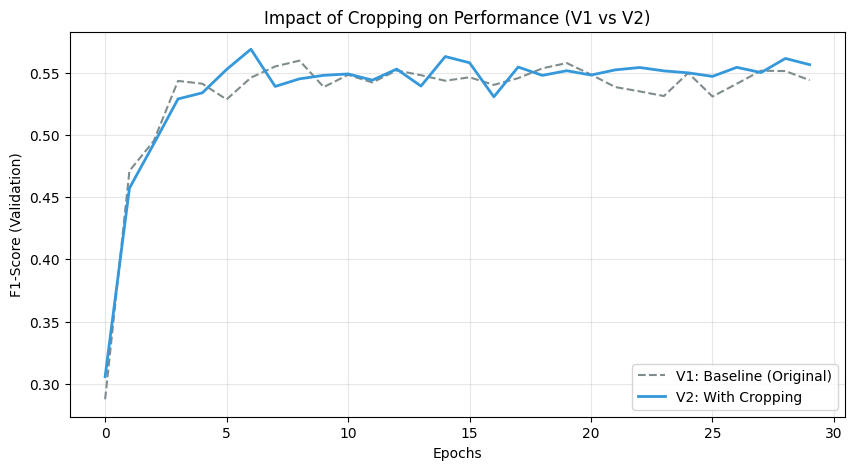

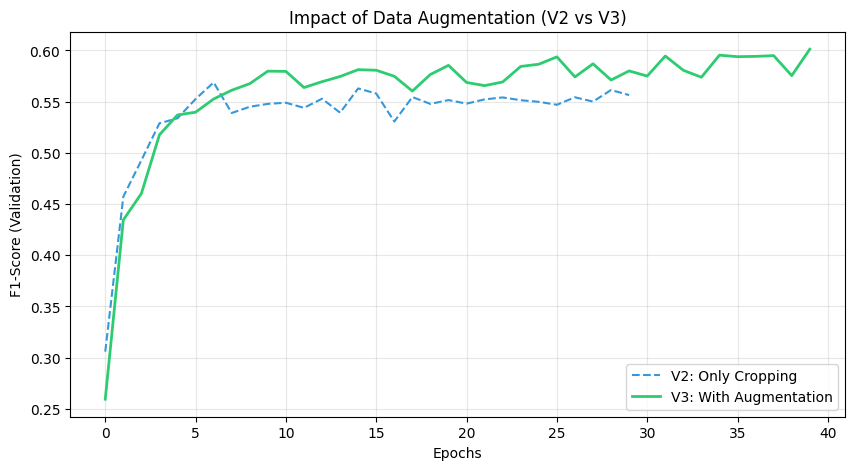

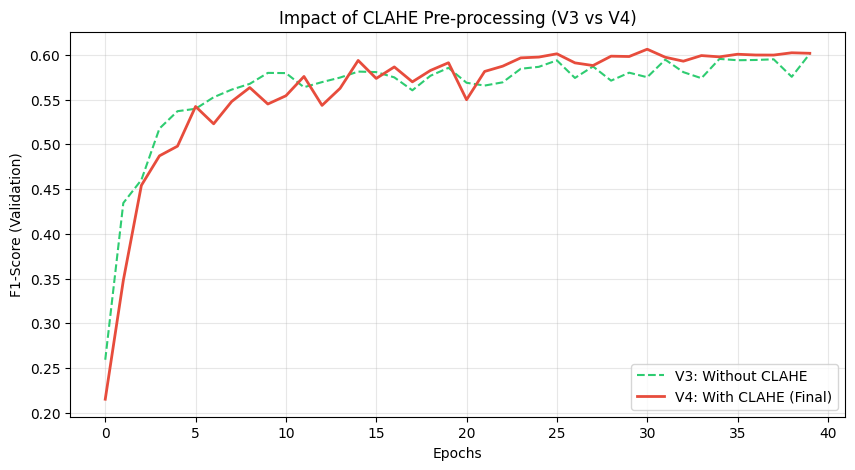

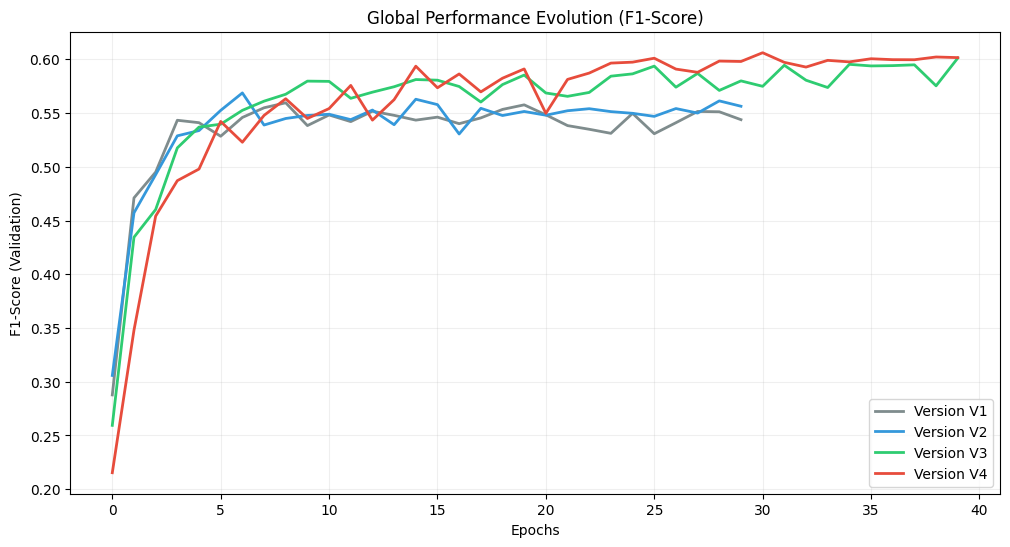


🎯 Calculating Optimized Thresholds for V4...


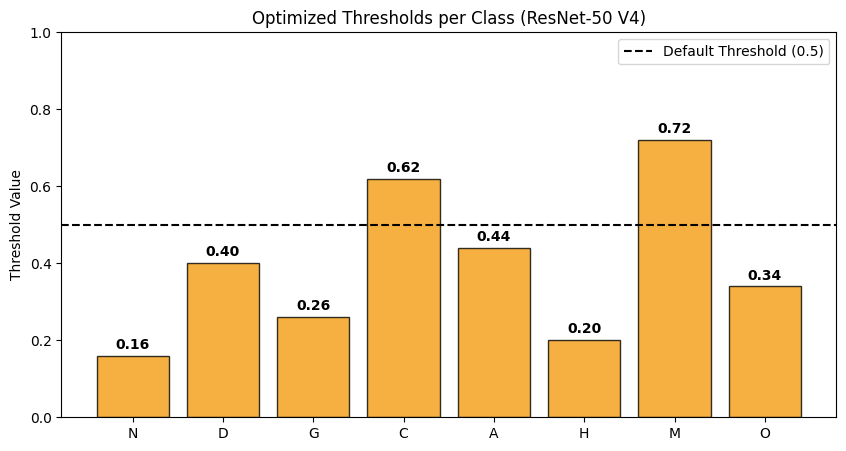


📋 Threshold Summary per Class:
   > Class N: 0.16
   > Class D: 0.40
   > Class G: 0.26
   > Class C: 0.62
   > Class A: 0.44
   > Class H: 0.20
   > Class M: 0.72
   > Class O: 0.34

🏆 RESUMO DE PERFORMANCE (ORIGINAL vs OTIMIZADO)
[V1] F1: 0.5439 ➡️ 0.5931 (Ganho: +0.0492)
[V2] F1: 0.5563 ➡️ 0.6069 (Ganho: +0.0506)
[V3] F1: 0.6011 ➡️ 0.6272 (Ganho: +0.0261)
[V4] F1: 0.6016 ➡️ 0.6363 (Ganho: +0.0347)


In [33]:
# ==========================================================
# 📊 SECTION: GRAPHICS & VISUALIZATIONS (COMPARATIVE STUDY)
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Define standard colors for consistency across all plots
colors = {'V1': '#7f8c8d', 'V2': '#3498db', 'V3': '#2ecc71', 'V4': '#e74c3c'}

# --- 1. IMPACT OF CROPPING (V1 vs V2) ---
if 'V1' in results_logs and 'V2' in results_logs:
    plt.figure(figsize=(10, 5))
    plt.plot(results_logs['V1']['history']['val_f1'], label='V1: Baseline (Original)', color=colors['V1'], linestyle='--')
    plt.plot(results_logs['V2']['history']['val_f1'], label='V2: With Cropping', color=colors['V2'], linewidth=2)
    plt.title('Impact of Cropping on Performance (V1 vs V2)')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score (Validation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('comparison_v1_v2_cropping.png')
    plt.show()

# --- 2. IMPACT OF DATA AUGMENTATION (V2 vs V3) ---
if 'V2' in results_logs and 'V3' in results_logs:
    plt.figure(figsize=(10, 5))
    plt.plot(results_logs['V2']['history']['val_f1'], label='V2: Only Cropping', color=colors['V2'], linestyle='--')
    plt.plot(results_logs['V3']['history']['val_f1'], label='V3: With Augmentation', color=colors['V3'], linewidth=2)
    plt.title('Impact of Data Augmentation (V2 vs V3)')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score (Validation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('comparison_v2_v3_augmentation.png')
    plt.show()

# --- 3. IMPACT OF CLAHE PRE-PROCESSING (V3 vs V4) ---
if 'V3' in results_logs and 'V4' in results_logs:
    plt.figure(figsize=(10, 5))
    plt.plot(results_logs['V3']['history']['val_f1'], label='V3: Without CLAHE', color=colors['V3'], linestyle='--')
    plt.plot(results_logs['V4']['history']['val_f1'], label='V4: With CLAHE (Final)', color=colors['V4'], linewidth=2)
    plt.title('Impact of CLAHE Pre-processing (V3 vs V4)')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score (Validation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('comparison_v3_v4_clahe.png')
    plt.show()

# --- 4. GLOBAL PERFORMANCE EVOLUTION ---
plt.figure(figsize=(12, 6))
for v in ['V1', 'V2', 'V3', 'V4']:
    if v in results_logs:
        plt.plot(results_logs[v]['history']['val_f1'], label=f'Version {v}', color=colors[v], linewidth=2)
plt.title('Global Performance Evolution (F1-Score)')
plt.xlabel('Epochs')
plt.ylabel('F1-Score (Validation)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.savefig('global_evolution_f1.png')
plt.show()

# --- 5. OPTIMIZATION AND VISUALIZATION OF THRESHOLDS (V4) ---
if 'V4' in results_logs:
    print("\n🎯 Calculating Optimized Thresholds for V4...")
    v4_res = results_logs['V4']
    
    # Calculate best thresholds
    best_thresholds_v4 = optimize_thresholds(np.array(v4_res['y_true']), np.array(v4_res['y_probs']))    
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    
    # Thresholds Bar Chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, best_thresholds_v4, color='#f39c12', alpha=0.8, edgecolor='black')
    plt.axhline(y=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
    
    # Add exact values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', 
                 ha='center', va='bottom', fontweight='bold')

    plt.title('Optimized Thresholds per Class (ResNet-50 V4)')
    plt.ylabel('Threshold Value')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.savefig('v4_thresholds_bar_chart.png')
    plt.show()

    # Print summary table to console
    print("\n📋 Threshold Summary per Class:")
    for i, cls in enumerate(classes):
        print(f"   > Class {cls}: {best_thresholds_v4[i]:.2f}")

# ==========================================================
# 📈 RELATÓRIO FINAL: OTIMIZAÇÃO GLOBAL
# ==========================================================
print("\n" + "="*50)
print("🏆 RESUMO DE PERFORMANCE (ORIGINAL vs OTIMIZADO)")
print("="*50)

summary_results = {}

for version in ['V1', 'V2', 'V3', 'V4']:
    if version in results_logs:
        data = results_logs[version]
        y_true = data['y_true']
        y_probs = data['y_probs']
        
        # 1. F1 Original (Threshold 0.5)
        f1_orig = f1_score(y_true, (y_probs > 0.5).astype(int), average='macro', zero_division=0)
        
        # 2. Encontrar melhores thresholds
        best_thresh = optimize_thresholds(y_true, y_probs)
        
        # 3. Aplicar novos thresholds
        y_pred_opt = np.zeros_like(y_probs)
        for i in range(8):
            y_pred_opt[:, i] = (y_probs[:, i] > best_thresh[i]).astype(int)
        
        f1_opt = f1_score(y_true, y_pred_opt, average='macro', zero_division=0)
        
        # Guardar para o sumário
        summary_results[version] = {
            'original': f1_orig,
            'optimized': f1_opt,
            'thresholds': best_thresh
        }
        
        print(f"[{version}] F1: {f1_orig:.4f} ➡️ {f1_opt:.4f} (Ganho: {f1_opt-f1_orig:+.4f})")

print("="*50)

## Grid Search (ResNet-50 V4)

🚀 Iniciando Grid Search Otimizado para ResNet-50 V4...

> 🧪 Testando: LR=1e-05 | Batch Size=16 | WD=0.05


Calculando pesos: 100%|██████████| 4474/4474 [01:26<00:00, 51.57it/s]


   ✅ Resultado: Best F1 = 0.5056

> 🧪 Testando: LR=5e-05 | Batch Size=16 | WD=0.05


Calculando pesos: 100%|██████████| 4474/4474 [01:27<00:00, 51.27it/s]


   ✅ Resultado: Best F1 = 0.5798

> 🧪 Testando: LR=0.0001 | Batch Size=16 | WD=0.05


Calculando pesos: 100%|██████████| 4474/4474 [01:24<00:00, 52.95it/s]


   ✅ Resultado: Best F1 = 0.6015

> 🧪 Testando: LR=1e-05 | Batch Size=32 | WD=0.05


Calculando pesos: 100%|██████████| 4474/4474 [01:24<00:00, 53.26it/s]


   ✅ Resultado: Best F1 = 0.4641

> 🧪 Testando: LR=5e-05 | Batch Size=32 | WD=0.05


Calculando pesos: 100%|██████████| 4474/4474 [01:23<00:00, 53.53it/s]


   ✅ Resultado: Best F1 = 0.5868

> 🧪 Testando: LR=0.0001 | Batch Size=32 | WD=0.05


Calculando pesos: 100%|██████████| 4474/4474 [01:23<00:00, 53.60it/s]


   ✅ Resultado: Best F1 = 0.5862


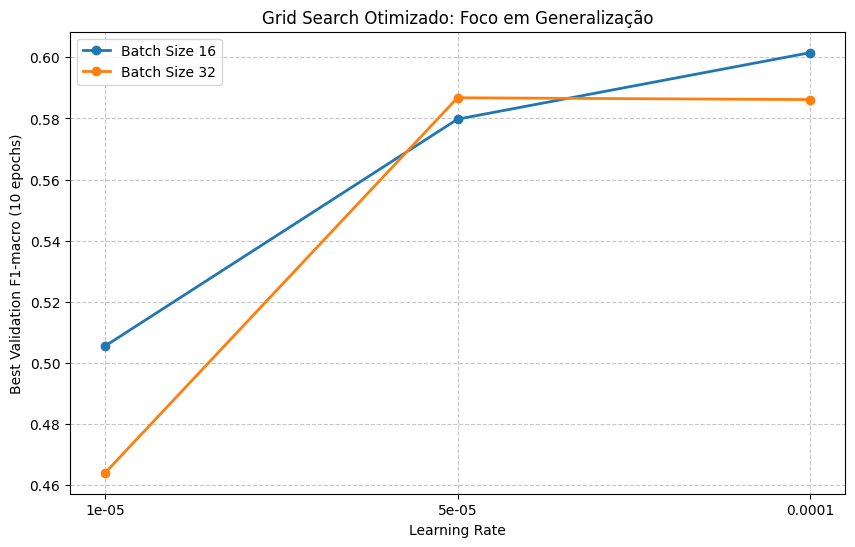

In [34]:
# ==========================================================
# 🚀 GRID SEARCH OTIMIZADO (ANTI-OVERFITTING)
# ==========================================================

param_grid = {
    'lr': [1e-5, 5e-5, 1e-4],      
    'batch_size': [16, 32],        
    'weight_decay': [0.05]         # Fixamos WD alto para forçar generalização
}

grid_results = []

print("🚀 Iniciando Grid Search Otimizado para ResNet-50 V4...")

# --- Definição manual da config V4 caso o dicionário 'configs' não exista ---
v4_config = {'crop': True, 'augment': 'full', 'clahe': True}

for bs in param_grid['batch_size']:
    # Usamos v4_config diretamente aqui
    train_ds_grid = ODIRDataset(split='train', transform=get_transforms(v4_config, is_train=True))
    val_ds_grid = ODIRDataset(split='val', transform=get_transforms(v4_config, is_train=False))
    
    train_loader_grid = DataLoader(train_ds_grid, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
    val_loader_grid = DataLoader(val_ds_grid, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)
    
    for lr in param_grid['lr']:
        print(f"\n> 🧪 Testando: LR={lr} | Batch Size={bs} | WD=0.05")
        
        model = get_optimized_resnet50(dropout_rate=0.5) # Já inclui Dropout
        weights = calculate_class_weights_clipped(train_ds_grid)
        
        # --- CORREÇÃO COMPATIBILIDADE LABEL SMOOTHING ---
        # Se o teu PyTorch for antigo, usamos a função manual que criámos antes
        base_criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
        def criterion(outputs, targets):
            eps = 0.1
            smoothed_targets = targets * (1 - eps) + 0.5 * eps
            return base_criterion(outputs, smoothed_targets)
        
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
        
        best_val_f1 = 0
        
        # Treino rápido de 10 épocas para validação de hiperparâmetros
        for epoch in range(10):
            model.train()
            for imgs, labels in train_loader_grid:
                imgs, labels = imgs.to(device), labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # Validação rápida
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for imgs, labels in val_loader_grid:
                    outputs = model(imgs.to(device))
                    probs = torch.sigmoid(outputs)
                    all_preds.append((probs > 0.5).cpu().numpy())
                    all_labels.append(labels.cpu().numpy()) 
            
            val_f1 = f1_score(np.vstack(all_labels), np.vstack(all_preds), average='macro', zero_division=0)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
        
        print(f"   ✅ Resultado: Best F1 = {best_val_f1:.4f}")
        grid_results.append({'lr': lr, 'batch_size': bs, 'f1': best_val_f1})
        
        # Limpar memória GPU
        del model
        torch.cuda.empty_cache()

# --- Salvar e Visualizar ---
with open("grid_search_results.json", "w") as f:
    json.dump(grid_results, f)

plt.figure(figsize=(10, 6))
for bs in param_grid['batch_size']:
    subset = [r for r in grid_results if r['batch_size'] == bs]
    lrs = [str(r['lr']) for r in subset]
    f1s = [r['f1'] for r in subset]
    plt.plot(lrs, f1s, marker='o', linewidth=2, label=f'Batch Size {bs}')

plt.xlabel('Learning Rate')
plt.ylabel('Best Validation F1-macro (10 epochs)')
plt.title('Grid Search Otimizado: Foco em Generalização')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [38]:
# 2. Hiperparâmetros baseados no Grid Search Otimizado
best_lr = 0.0001 # Costuma ser o vencedor no Grid Search para ResNet
best_bs = 16   # Batch size 32 oferece um bom equilíbrio entre estabilidade e memória
print(f"🏆 Final Configuration Fixed: LR={best_lr}, Batch={best_bs}, WD=0.05")

configs = {
    'V4_Best': {'crop': True, 'augment': 'full', 'clahe': True}
}

# 3. Setup DataLoaders (Adicionado pin_memory e num_workers para velocidade)
train_ds = ODIRDataset(split='train', transform=get_transforms(configs['V4_Best'], is_train=True))
val_ds = ODIRDataset(split='val', transform=get_transforms(configs['V4_Best'], is_train=False))

train_loader_final = DataLoader(train_ds, batch_size=best_bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader_final = DataLoader(val_ds, batch_size=best_bs, num_workers=2, pin_memory=True)

# 4. Initialize Model (Usando Dropout 0.5 para generalização)
model = get_optimized_resnet50(dropout_rate=0.5).to(device) 

# Optimizer com Weight Decay do Grid Search
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3) # Patience reduzida para agir rápido

# 5. Pesos e Critério com Label Smoothing Manual
weights = calculate_class_weights_clipped(train_ds)
base_criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

def criterion(outputs, targets):
    eps = 0.15 # Ligeiramente aumentado para maior robustez
    smoothed_targets = targets * (1 - eps) + 0.5 * eps
    return base_criterion(outputs, smoothed_targets)

history_v4_best = {'loss': [], 'val_f1': []}
best_f1_global = 0
final_v_probs = [] 
final_v_labels = []

# 6. Training Loop (Aumentamos a robustez do loop)
for epoch in range(40): # 40 épocas são suficientes com Early Stopping manual
    model.train()
    epoch_loss = 0
    for imgs, labels in tqdm(train_loader_final, desc=f"Epoch {epoch+1}/40"):
        imgs, labels = imgs.to(device), labels.to(device).float()
        optimizer.zero_grad(set_to_none=True) # Mais eficiente que zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    

    # Validation
    model.eval()
    v_probs_batch, v_labels_batch = [], [] 
    with torch.no_grad():
        for imgs, labels in val_loader_final:
            outputs = model(imgs.to(device))
            v_probs_batch.append(torch.sigmoid(outputs).cpu().numpy()) # Aplicar SIGMOID aqui!
            v_labels_batch.append(labels.numpy())
    
    y_true_epoch = np.vstack(v_labels_batch)
    y_probs_epoch = np.vstack(v_probs_batch)
    y_preds_epoch = (y_probs_epoch > 0.5).astype(int)
    
    val_f1 = f1_score(y_true_epoch, y_preds_epoch, average='macro', zero_division=0)
    scheduler.step(val_f1)
    
    history_v4_best['loss'].append(epoch_loss/len(train_loader_final))
    history_v4_best['val_f1'].append(val_f1)
    
    if val_f1 > best_f1_global:
        best_f1_global = val_f1
        torch.save(model.state_dict(), "resnet50_v4_best_final.pth")
        final_v_probs = y_probs_epoch
        final_v_labels = y_true_epoch
        print(f"✨ Checkpoint: New Best Val F1 = {val_f1:.4f}")

# 7. Log Final
results_logs['V4'] = {
    'history': history_v4_best, 
    'y_true': final_v_labels.tolist(), 
    'y_probs': final_v_probs.tolist()
}
print("\n✅ Final Training Complete!")
save_results_to_json(results_logs)

🏆 Final Configuration Fixed: LR=0.0001, Batch=16, WD=0.05


Epoch 1/40: 100%|██████████| 280/280 [00:47<00:00,  5.85it/s]


✨ Checkpoint: New Best Val F1 = 0.4137


Epoch 2/40: 100%|██████████| 280/280 [00:47<00:00,  5.86it/s]


✨ Checkpoint: New Best Val F1 = 0.4593


Epoch 3/40: 100%|██████████| 280/280 [00:47<00:00,  5.84it/s]


✨ Checkpoint: New Best Val F1 = 0.5107


Epoch 4/40: 100%|██████████| 280/280 [00:46<00:00,  5.98it/s]


✨ Checkpoint: New Best Val F1 = 0.5204


Epoch 5/40: 100%|██████████| 280/280 [00:48<00:00,  5.79it/s]


✨ Checkpoint: New Best Val F1 = 0.5845


Epoch 6/40: 100%|██████████| 280/280 [00:47<00:00,  5.86it/s]


✨ Checkpoint: New Best Val F1 = 0.5910


Epoch 11/40: 100%|██████████| 280/280 [00:47<00:00,  5.95it/s]


✨ Checkpoint: New Best Val F1 = 0.5990


Epoch 21/40: 100%|██████████| 280/280 [00:47<00:00,  5.95it/s]


✨ Checkpoint: New Best Val F1 = 0.6020


Epoch 22/40: 100%|██████████| 280/280 [00:47<00:00,  5.84it/s]


✨ Checkpoint: New Best Val F1 = 0.6040


Epoch 24/40: 100%|██████████| 280/280 [00:48<00:00,  5.79it/s]


✨ Checkpoint: New Best Val F1 = 0.6057


Epoch 27/40: 100%|██████████| 280/280 [00:46<00:00,  6.05it/s]


✨ Checkpoint: New Best Val F1 = 0.6086


Epoch 34/40: 100%|██████████| 280/280 [00:46<00:00,  5.97it/s]


✨ Checkpoint: New Best Val F1 = 0.6089


Epoch 40/40: 100%|██████████| 280/280 [00:51<00:00,  5.41it/s]



✅ Final Training Complete!
✅ Resultados salvos com sucesso em: odir_experiment_results.json



🔍 Calculating optimized thresholds for V4...

📊 EVALUATION REPORT: V1
⚙️ Using default threshold (0.5)...
Overall Accuracy: 0.3952
F1-Macro:         0.5486
Cohen's Kappa:    0.3611
AUC-ROC:          0.7900

F1-Score per Disease:
 - N: 0.5618
 - D: 0.5970
 - G: 0.5324
 - C: 0.7107
 - A: 0.5185
 - H: 0.2623
 - M: 0.7805
 - O: 0.4258


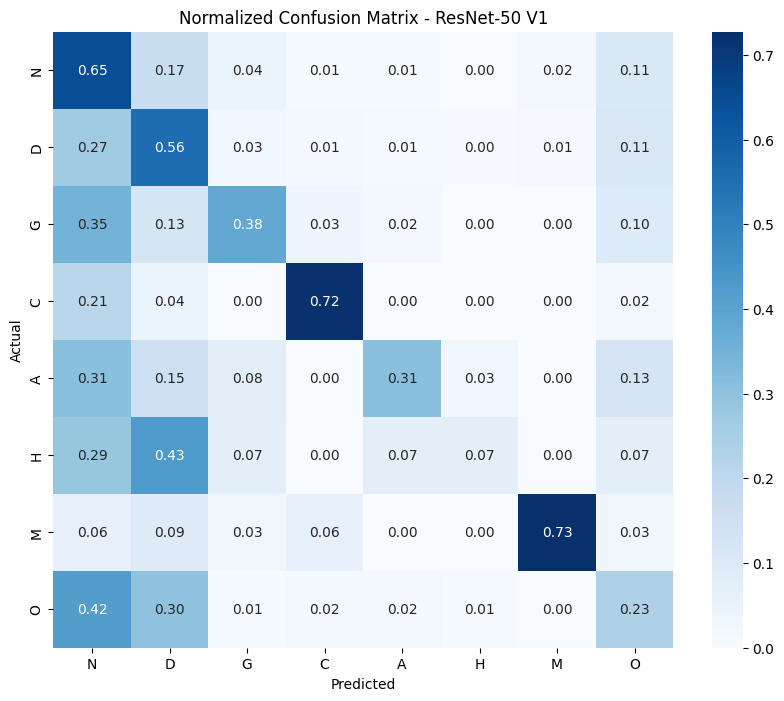

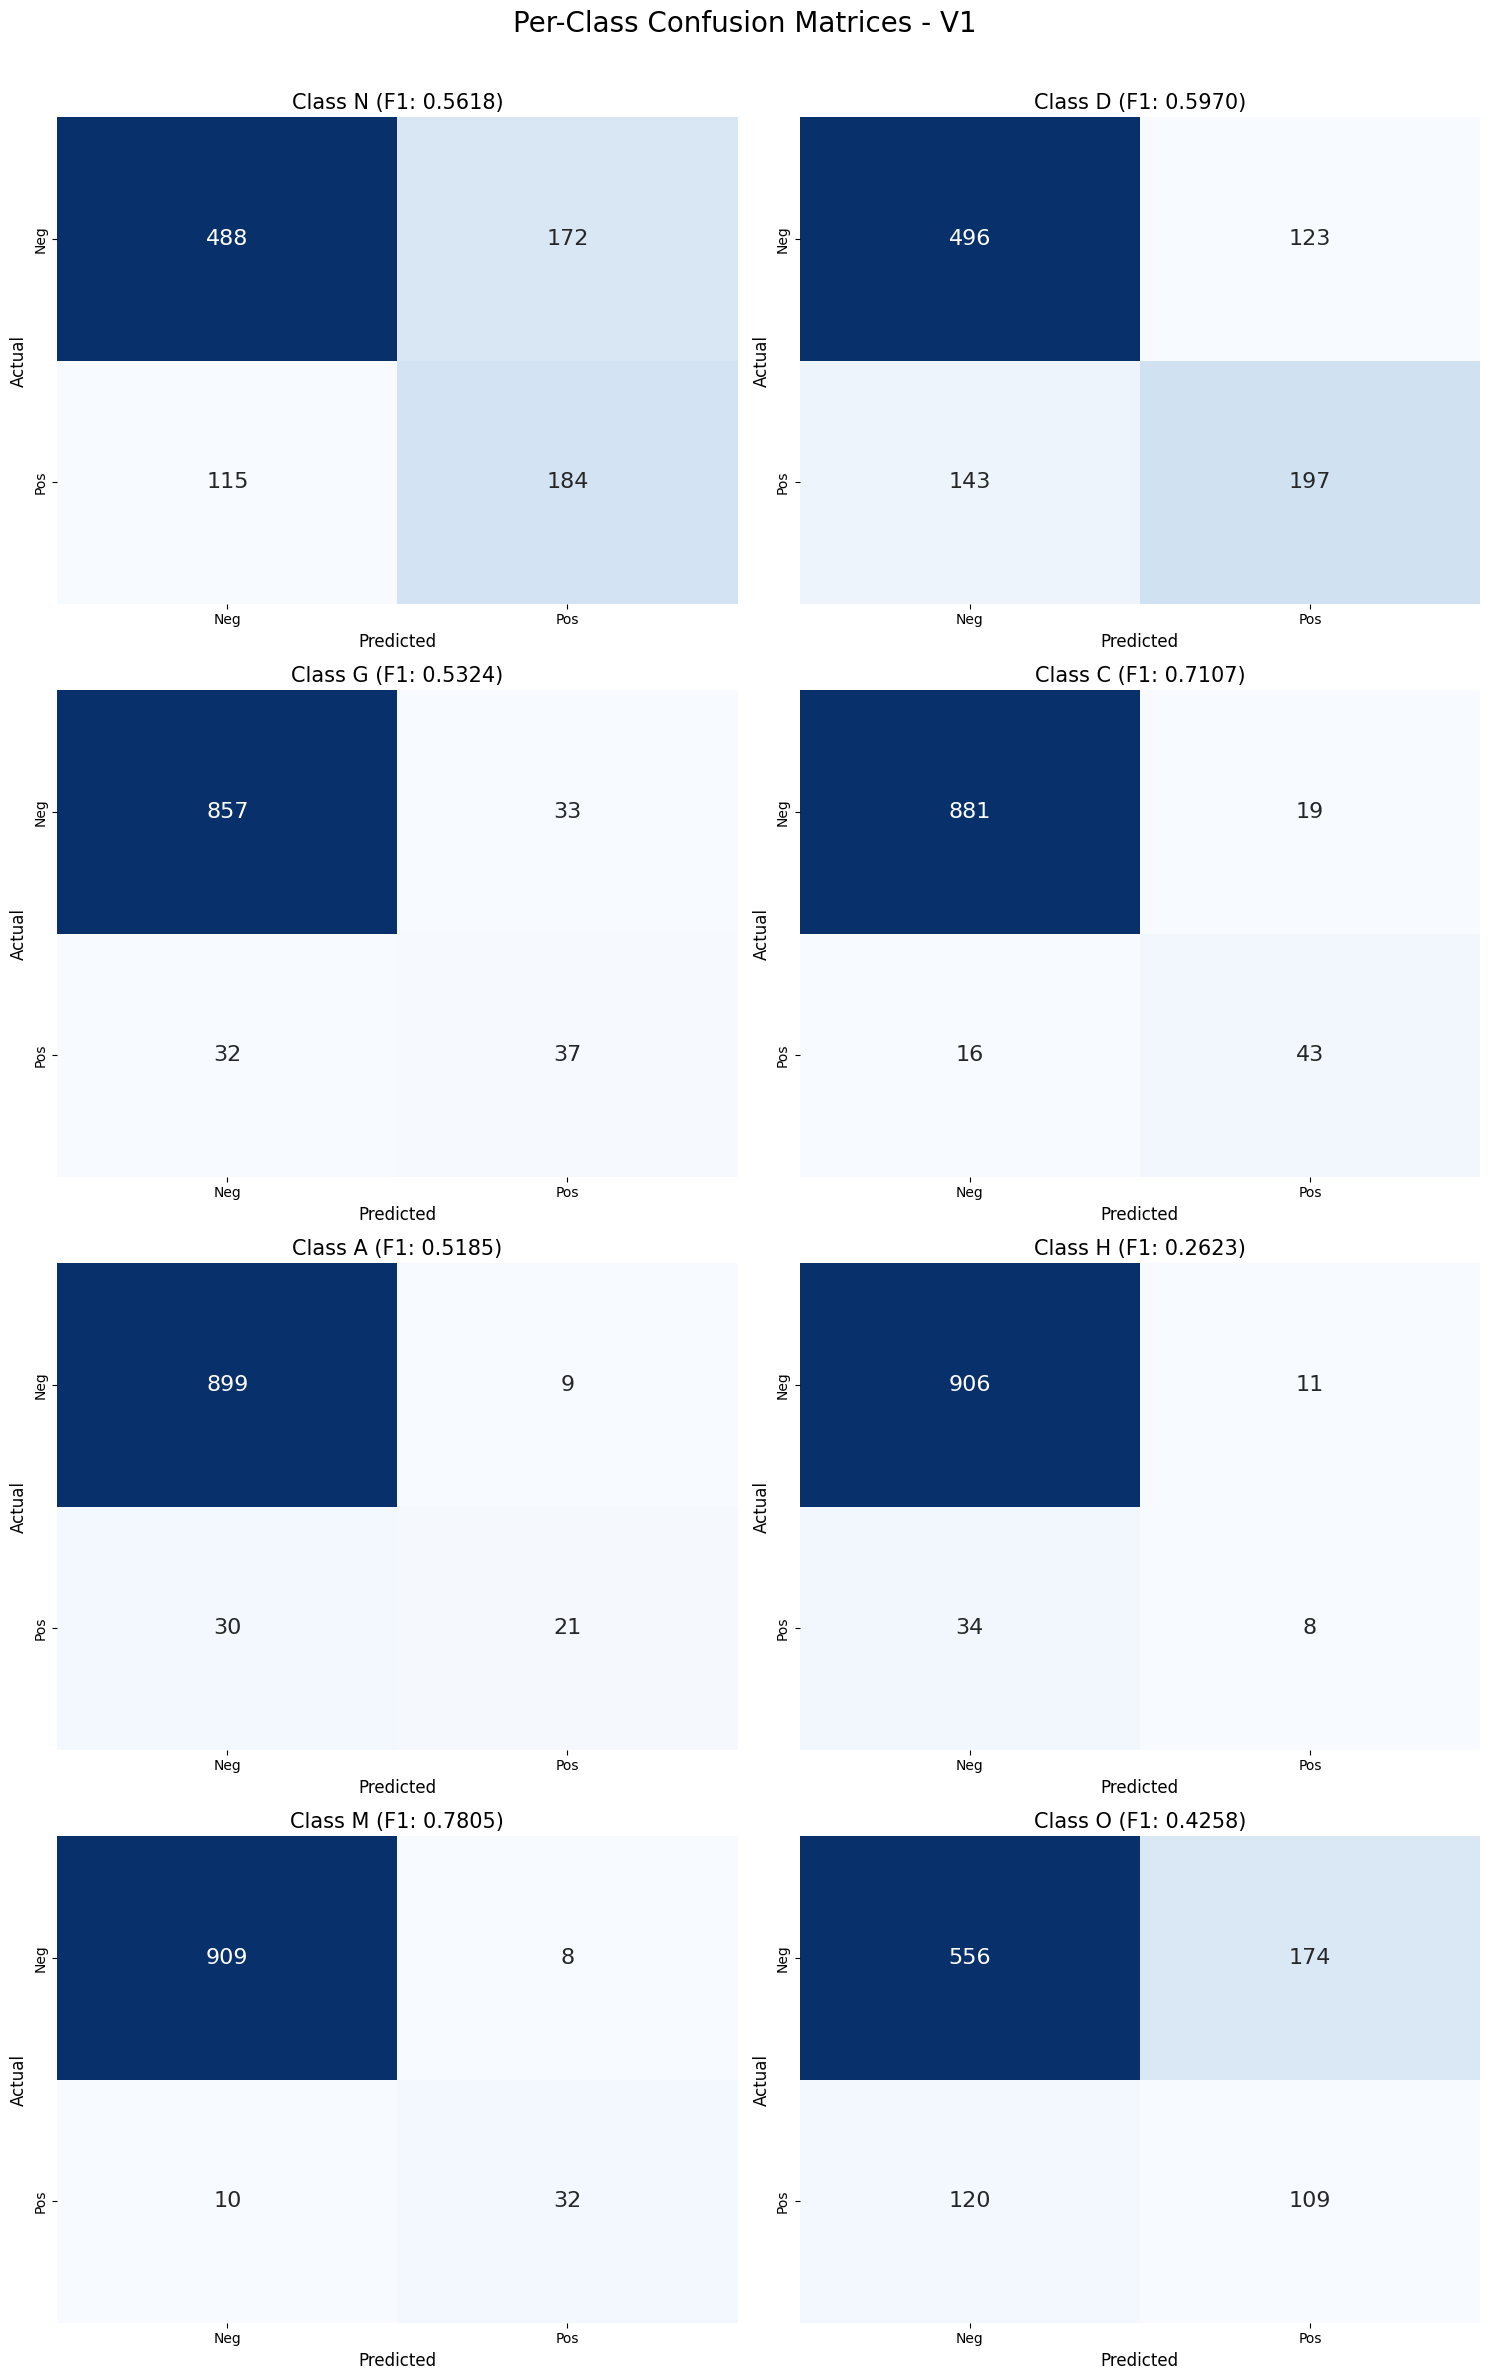


📊 EVALUATION REPORT: V2
⚙️ Using default threshold (0.5)...
Overall Accuracy: 0.3806
F1-Macro:         0.4942
Cohen's Kappa:    0.3136
AUC-ROC:          0.7842

F1-Score per Disease:
 - N: 0.5692
 - D: 0.5496
 - G: 0.3810
 - C: 0.7080
 - A: 0.4673
 - H: 0.1538
 - M: 0.7342
 - O: 0.3905


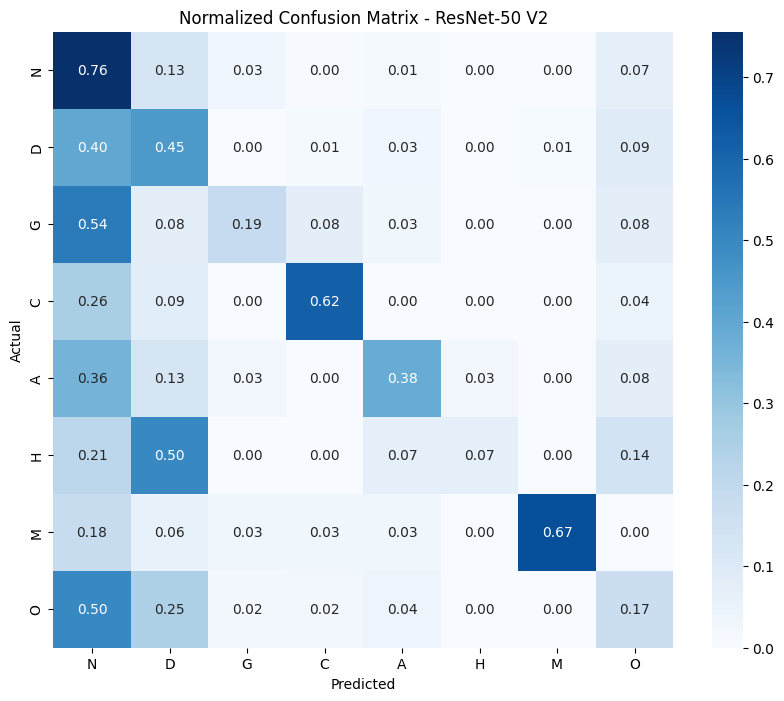

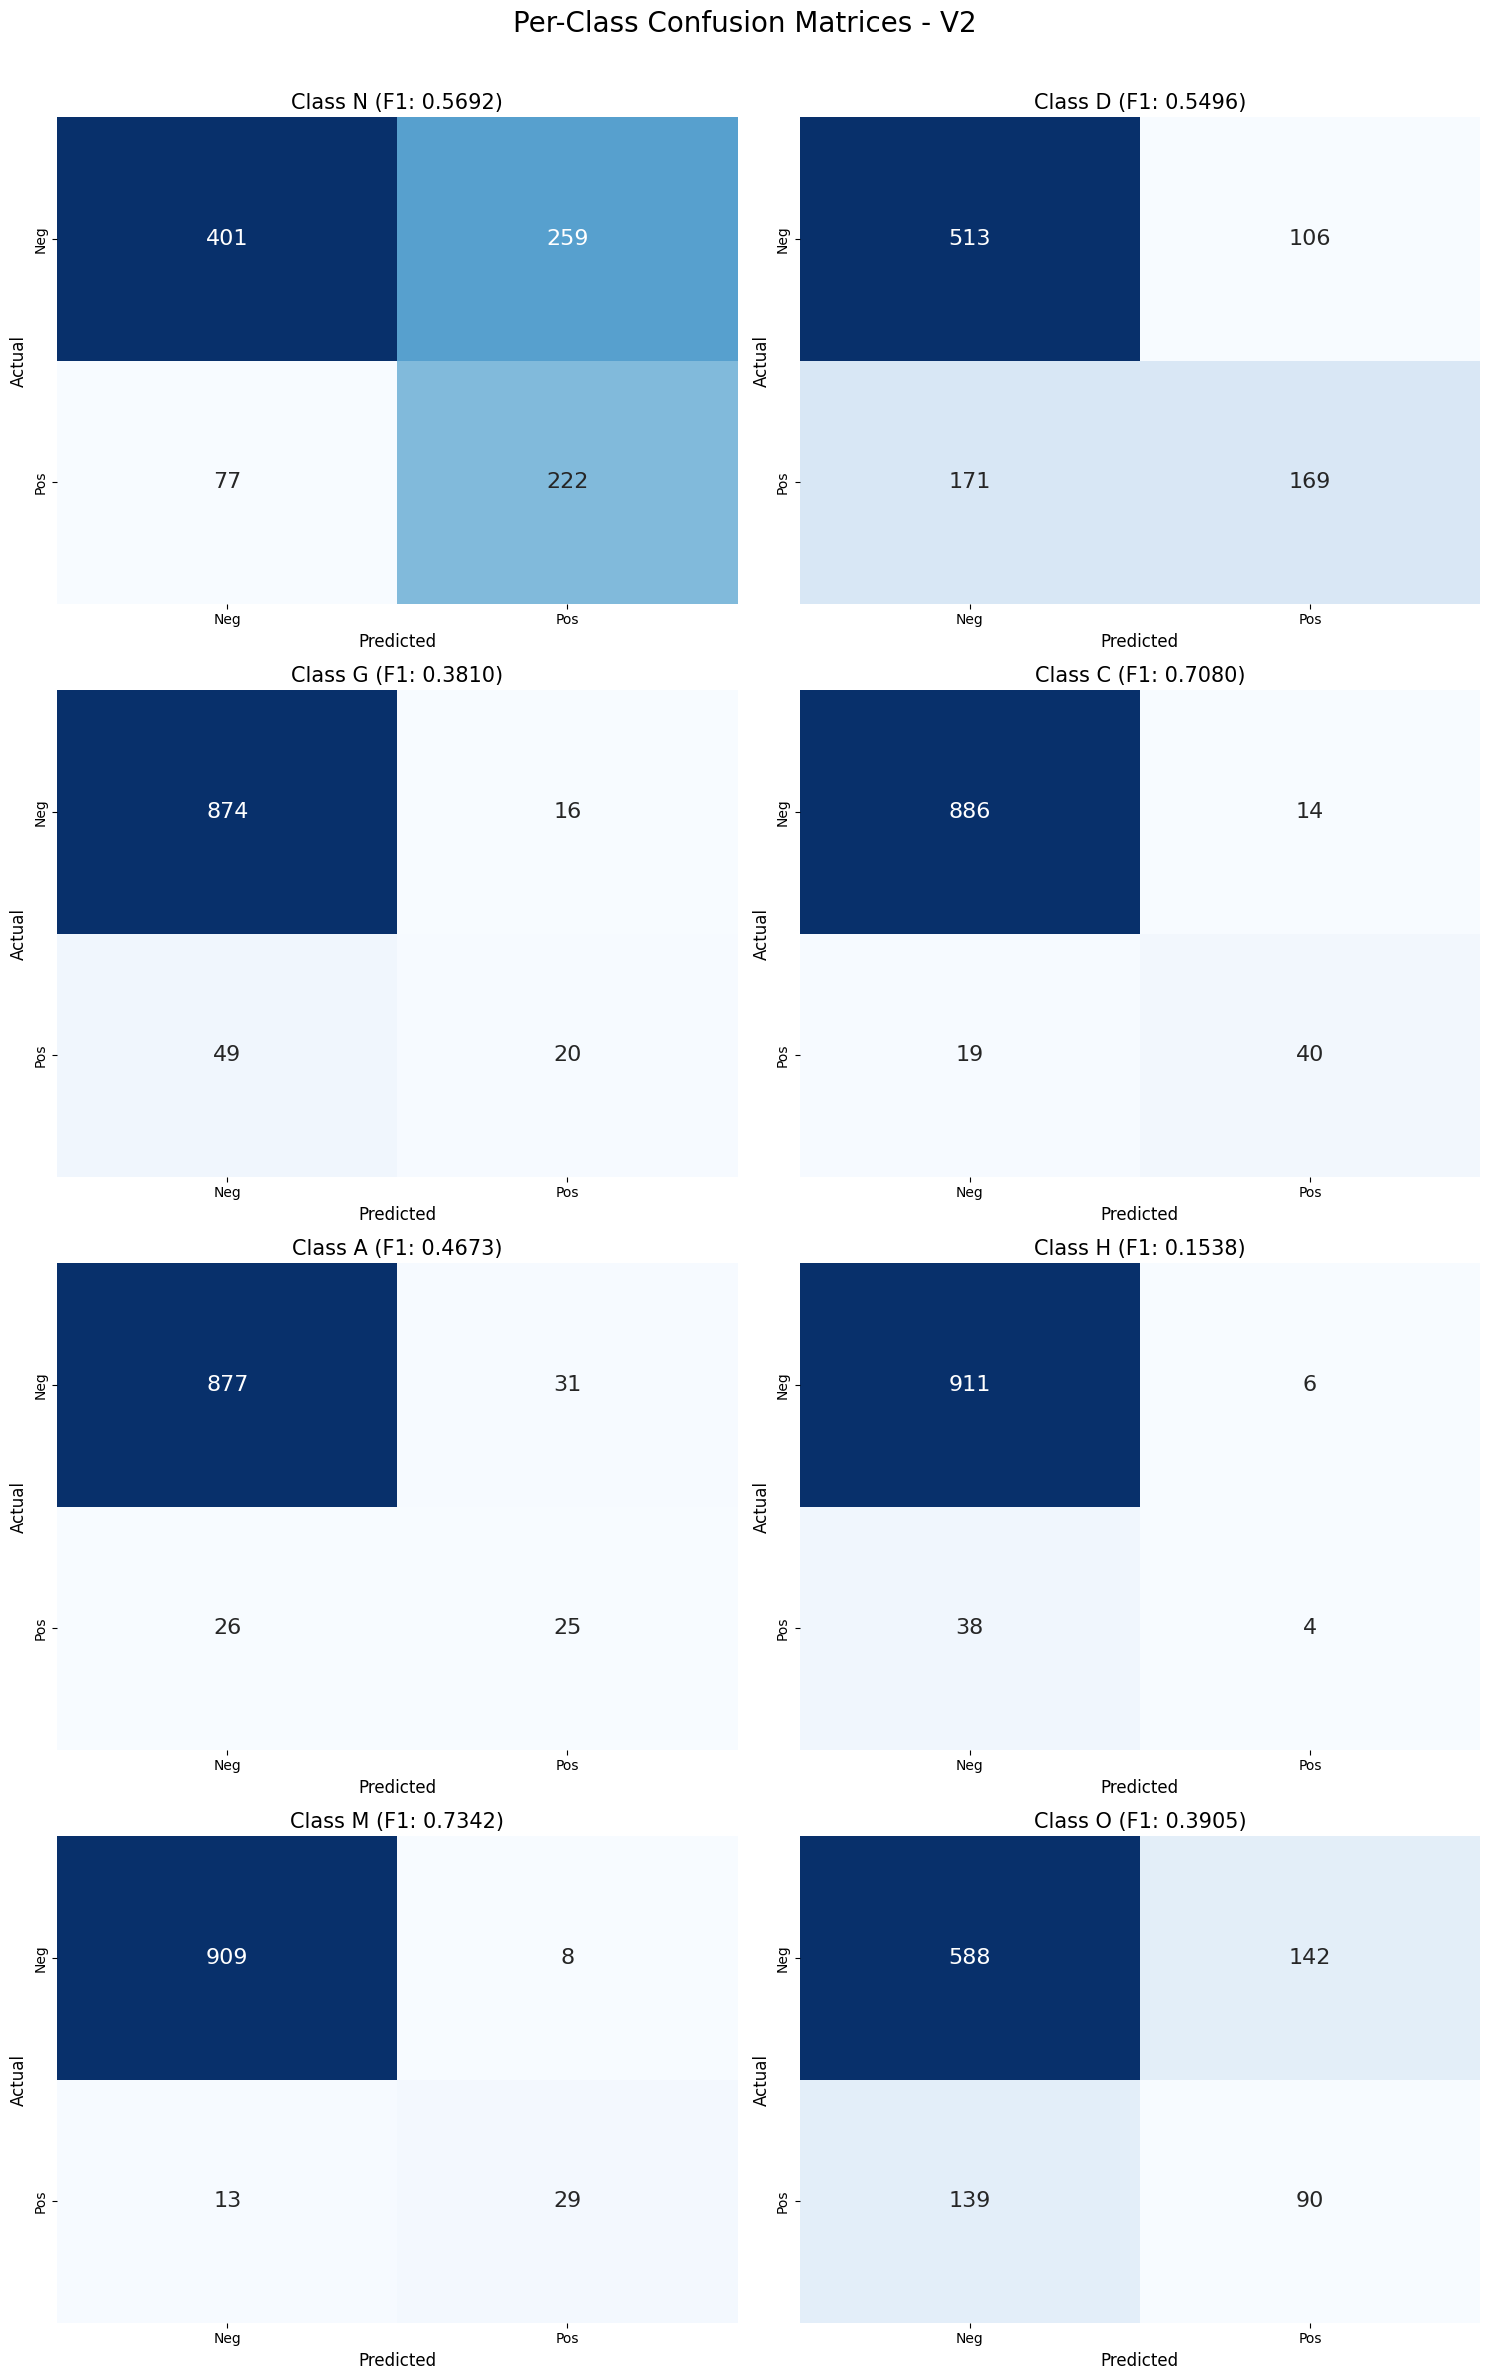


📊 EVALUATION REPORT: V3
⚙️ Using default threshold (0.5)...
Overall Accuracy: 0.4442
F1-Macro:         0.5624
Cohen's Kappa:    0.4006
AUC-ROC:          0.8139

F1-Score per Disease:
 - N: 0.5777
 - D: 0.6506
 - G: 0.5082
 - C: 0.6721
 - A: 0.5169
 - H: 0.3000
 - M: 0.7887
 - O: 0.4854


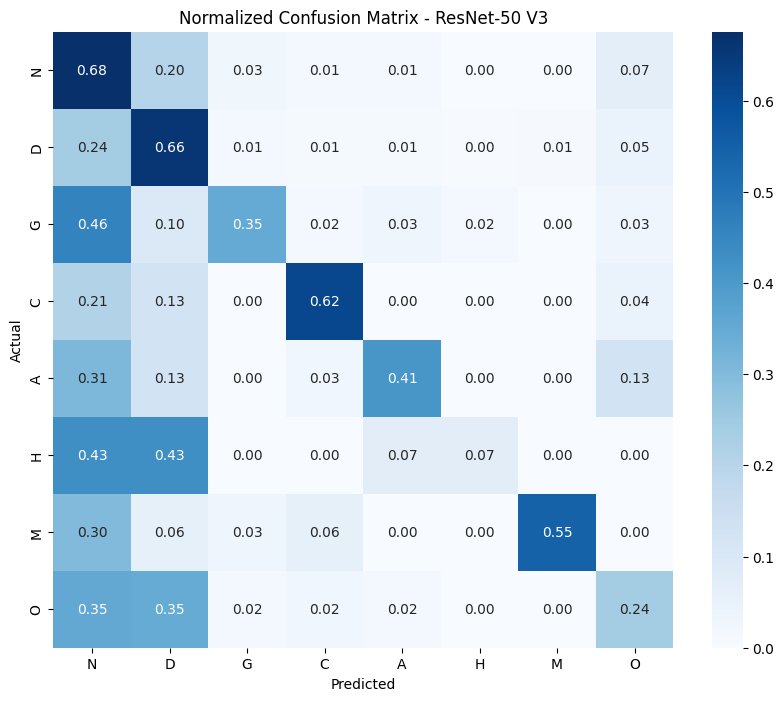

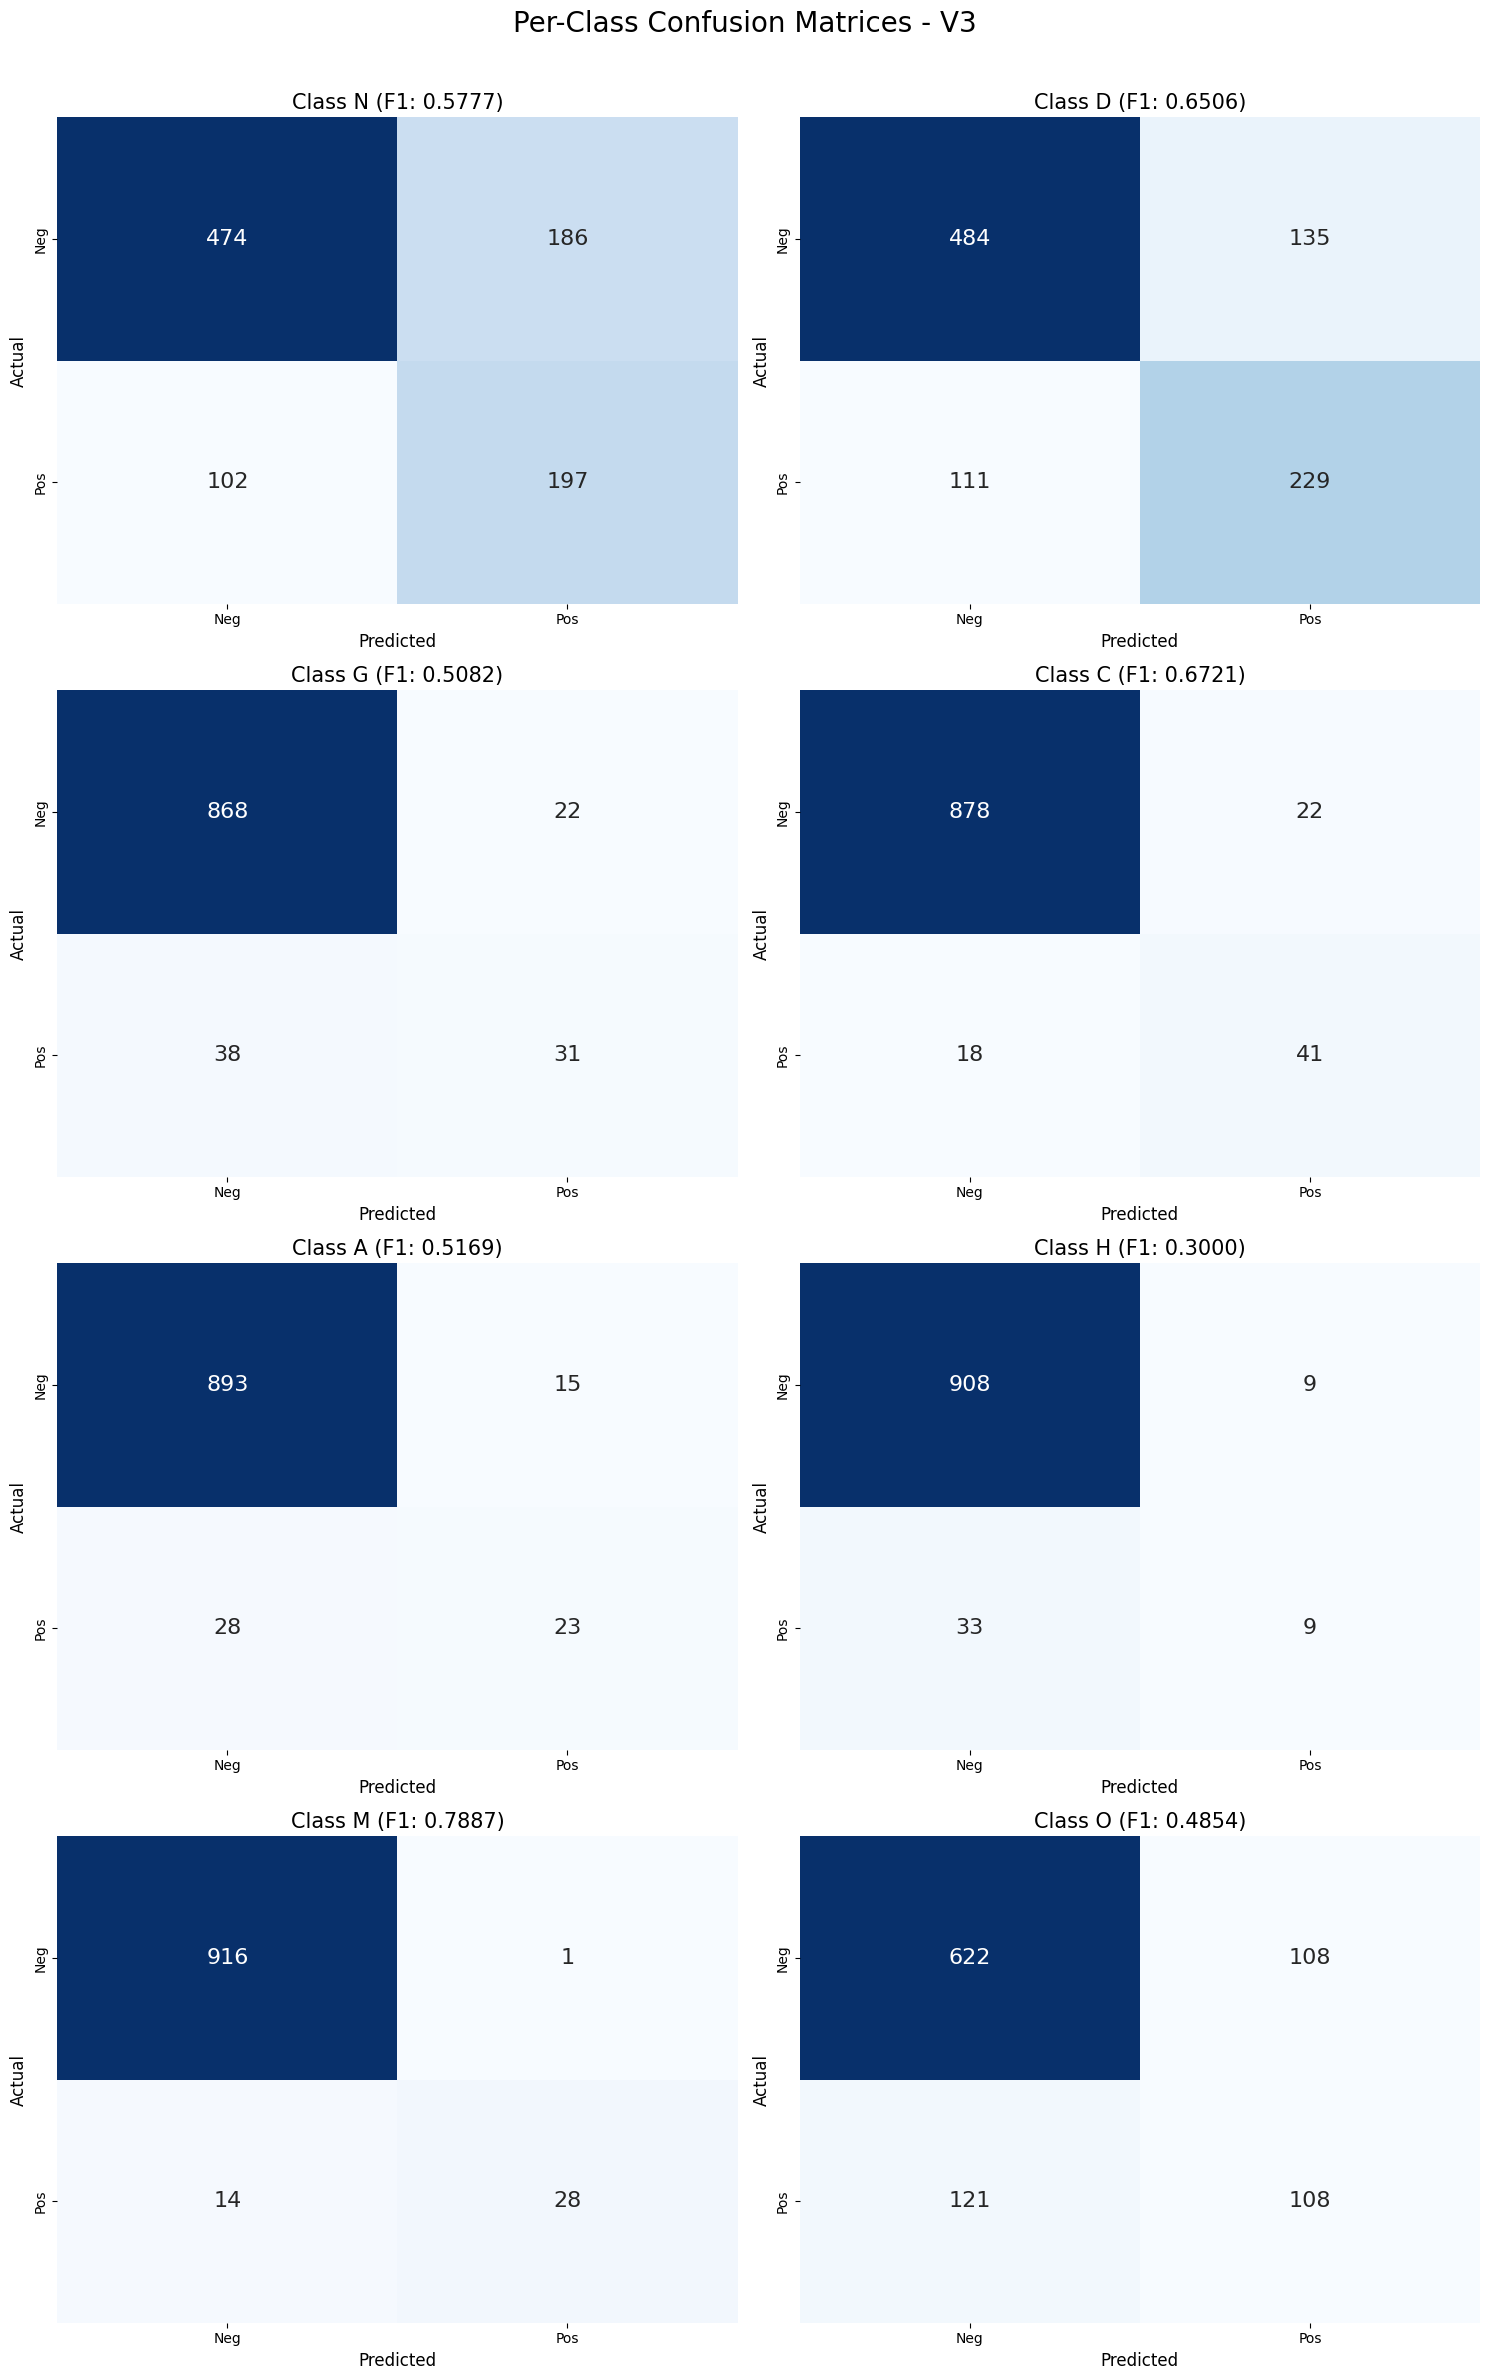


📊 EVALUATION REPORT: V4_Best
⚙️ Applying optimized thresholds...
Overall Accuracy: 0.3368
F1-Macro:         0.6027
Cohen's Kappa:    0.4147
AUC-ROC:          0.8351

F1-Score per Disease:
 - N: 0.6201
 - D: 0.6535
 - G: 0.5806
 - C: 0.7593
 - A: 0.5882
 - H: 0.4286
 - M: 0.7397
 - O: 0.4514


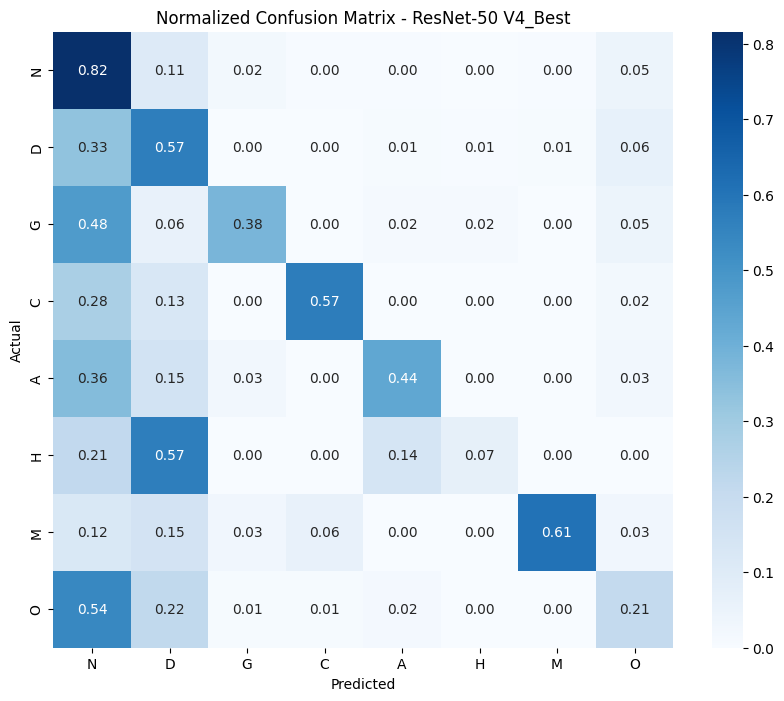

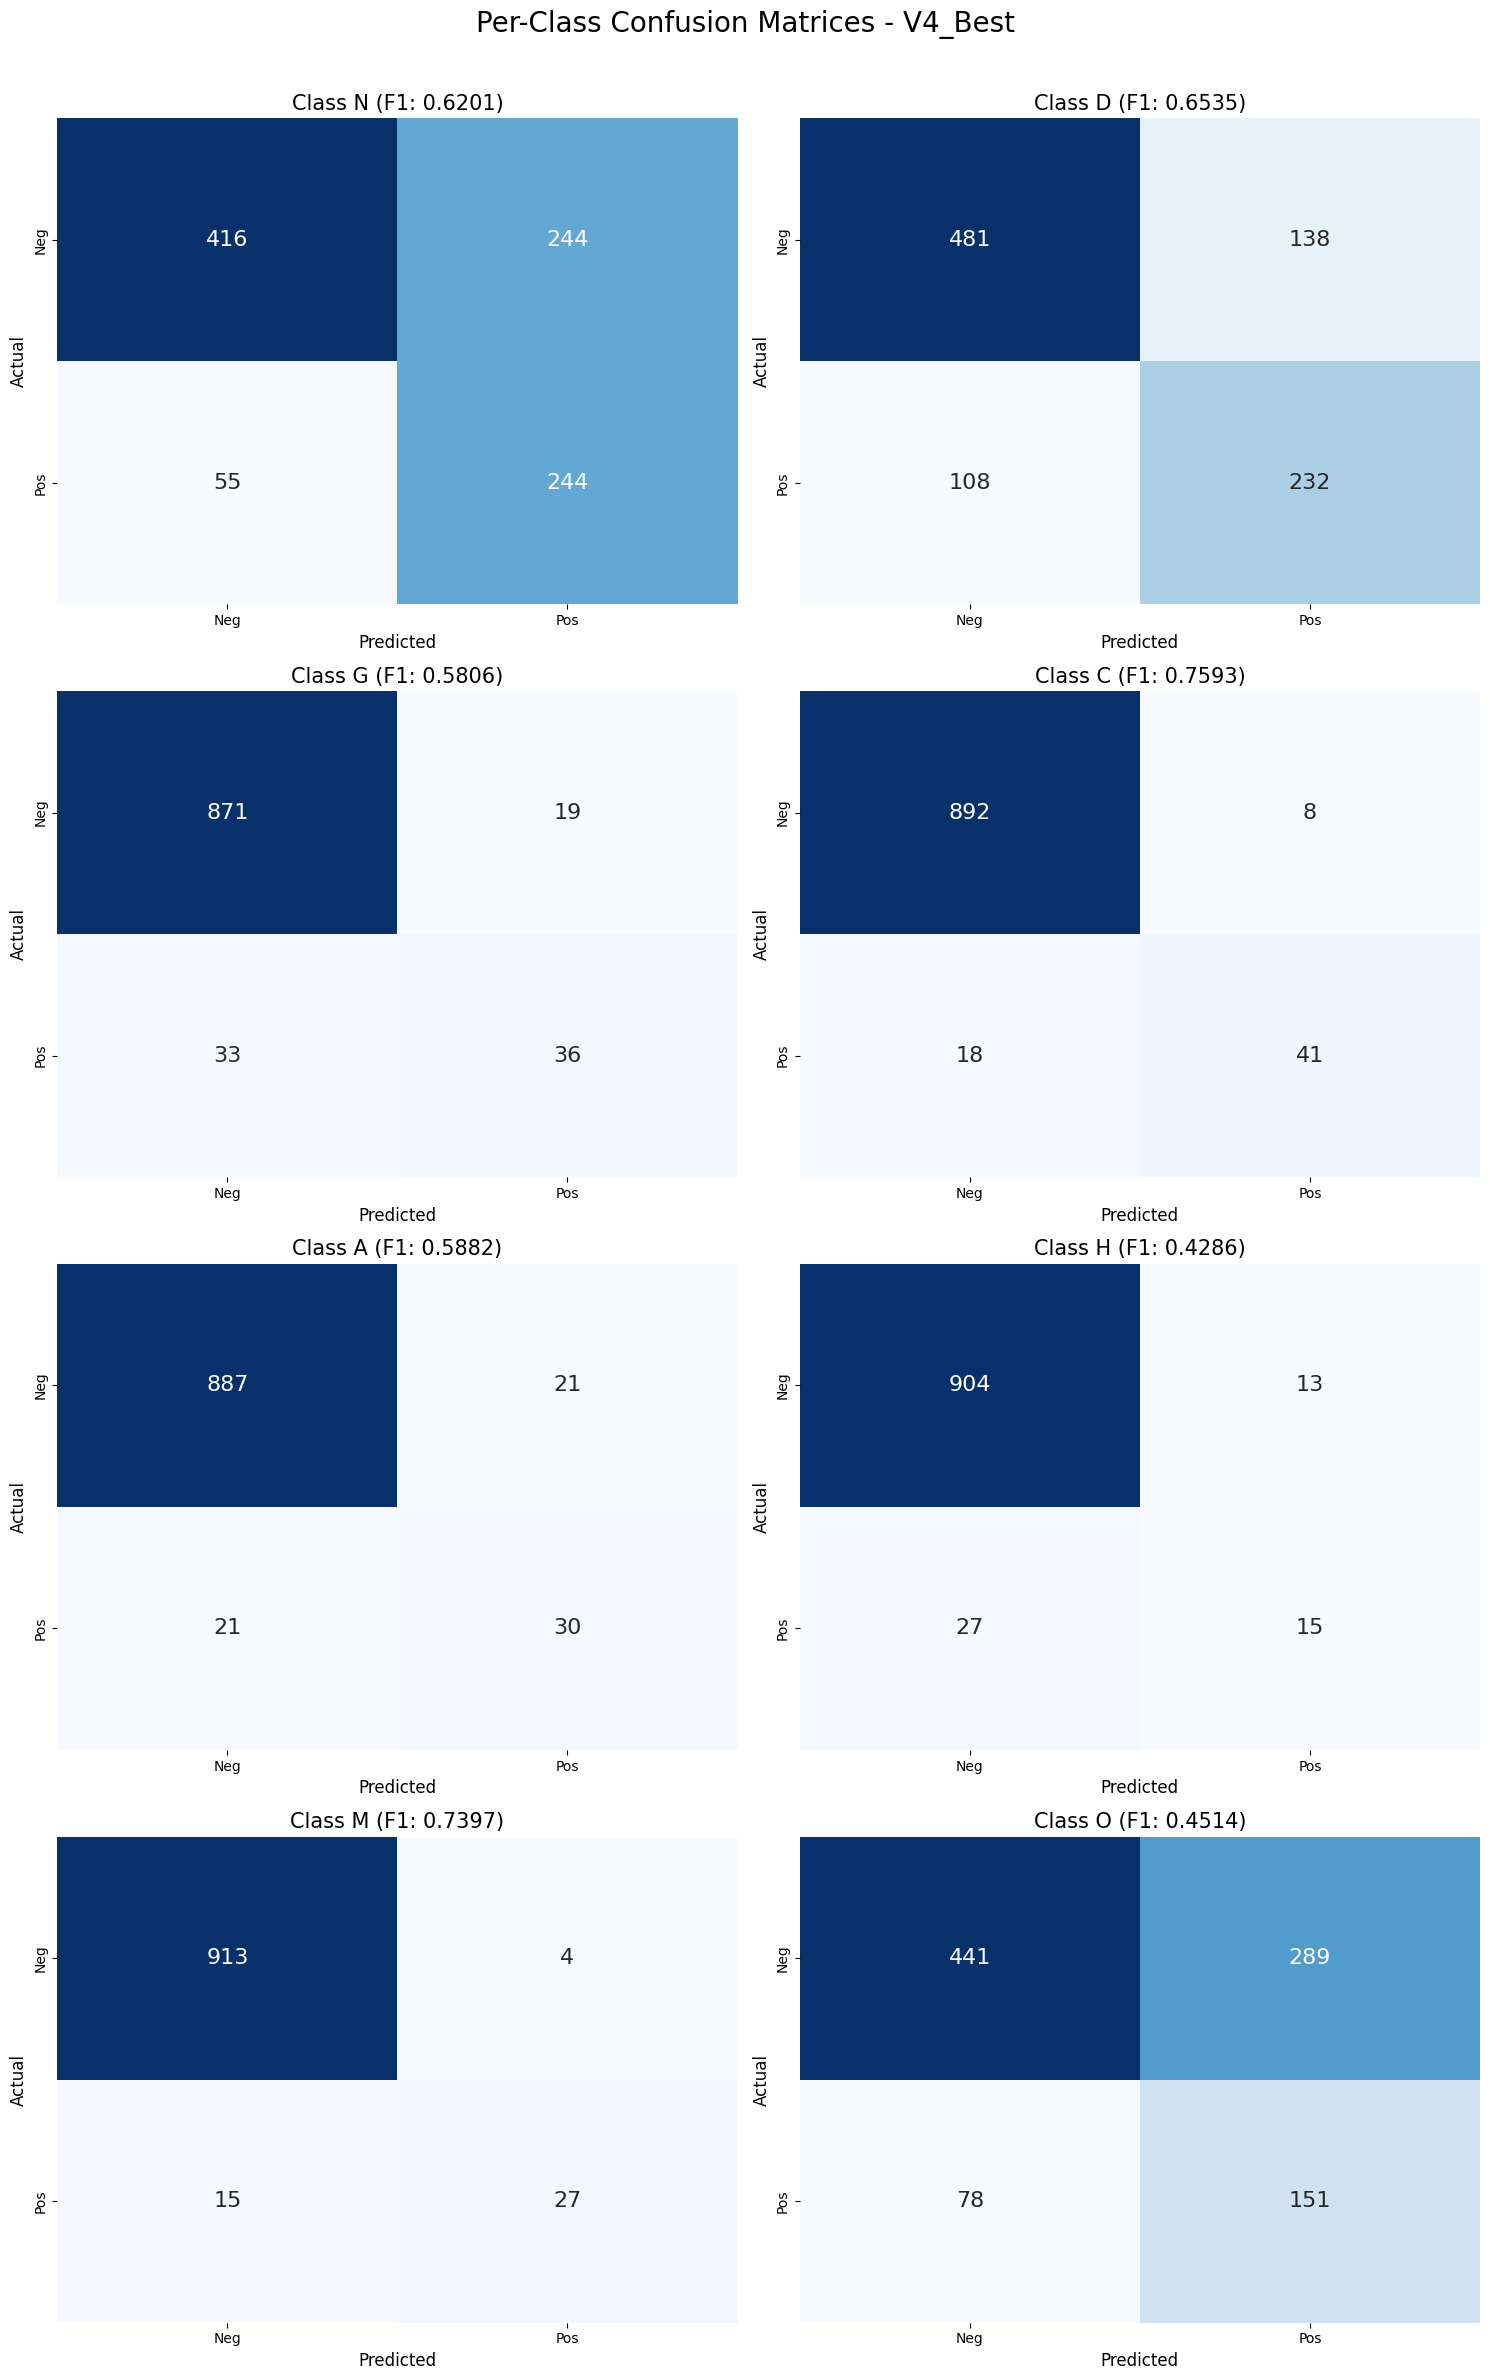


✅ Evaluation complete! Metrics saved to: /kaggle/working/odir_final_evaluation_metrics.json


In [39]:
from sklearn.metrics import multilabel_confusion_matrix
def final_evaluation_report(model_path, config, version_name, thresholds=None):
    print(f"\n" + "="*40)
    print(f"📊 EVALUATION REPORT: {version_name}")
    print("="*40)
    
    model = get_optimized_resnet50() 
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    test_ds = ODIRDataset(split='test', transform=get_transforms(config))
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
    
    y_true, y_logits = [], [] # Mudamos o nome para clareza
    with torch.no_grad():
        for imgs, labels in test_loader:
            outputs = model(imgs.to(device))
            y_logits.append(outputs.cpu().numpy())
            y_true.append(labels.numpy())
    
    y_true = np.vstack(y_true)
    y_logits = np.vstack(y_logits)
    
    # --- A LINHA CRUCIAL: CONVERTER LOGITS EM PROBABILIDADES ---
    y_prob = torch.sigmoid(torch.tensor(y_logits)).numpy()
    
    # Threshold Application
    if thresholds is not None:
        print("⚙️ Applying optimized thresholds...")
        y_pred = np.zeros_like(y_prob)
        for i in range(8):
            y_pred[:, i] = (y_prob[:, i] > thresholds[i]).astype(int)
    else:
        print("⚙️ Using default threshold (0.5)...")
        y_pred = (y_prob > 0.5).astype(int)
        
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    
    # 1. Metric Calculation
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    kappa = cohen_kappa_score(y_true.argmax(1), y_pred.argmax(1))
    auc_roc = roc_auc_score(y_true, y_prob, average='macro')
    
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"F1-Macro:         {f1_macro:.4f}")
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"AUC-ROC:          {auc_roc:.4f}")

    # 2. F1-Score per Class
    f1_per_class = {}
    print("\nF1-Score per Disease:")
    for i, cls in enumerate(classes):
        score = f1_score(y_true[:, i], y_pred[:, i])
        f1_per_class[cls] = float(score)
        print(f" - {cls}: {score:.4f}")
        
    # 3. Normalized Confusion Matrix (Graphic in English)
    cm = confusion_matrix(y_true.argmax(1), y_pred.argmax(1), normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - ResNet-50 {version_name}')
    plt.xlabel('Predicted') # Translated
    plt.ylabel('Actual')    # Translated
    plt.savefig(f'confusion_matrix_{version_name.lower()}.png')
    plt.show()

    # --- 5. Matrizes de Confusão por Classe (Grelha 2 por linha) ---
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    # Criamos uma grelha de 4 linhas e 2 colunas para totalizar as 8 classes
    fig, axes = plt.subplots(4, 2, figsize=(15, 25)) 
    fig.suptitle(f'Per-Class Confusion Matrices - {version_name}', fontsize=20)
    
    f1_per_class = {}
    for i, (matrix, cls) in enumerate(zip(mcm, classes)):
        row, col = i // 2, i % 2 # Lógica para organizar 2 por linha
        ax = axes[row, col]
        
        score = f1_score(y_true[:, i], y_pred[:, i])
        f1_per_class[cls] = float(score)
        
        sns.heatmap(matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False, annot_kws={"size": 16})
        ax.set_title(f'Class {cls} (F1: {score:.4f})', fontsize=15)
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
        ax.set_xticklabels(['Neg', 'Pos'])
        ax.set_yticklabels(['Neg', 'Pos'])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(f'per_class_report_{version_name.lower()}.png', dpi=300)
    plt.show()

    return {
        'overall_accuracy': float(acc),
        'f1_macro': float(f1_macro),
        'cohen_kappa': float(kappa),
        'auc_roc': float(auc_roc),
        'f1_per_class': f1_per_class,
        'thresholds_used': thresholds.tolist() if thresholds is not None else None
    }

# --- 1. Report Configurations ---
configs = {
    'V1': {'crop': False, 'augment': 'none', 'clahe': False},
    'V2': {'crop': True, 'augment': 'none', 'clahe': False},
    'V3': {'crop': True, 'augment': 'full', 'clahe': False},
    'V4_Best': {'crop': True, 'augment': 'full', 'clahe': True}
}

# --- 2. Threshold Optimization (V4 Only) ---
print("\n🔍 Calculating optimized thresholds for V4...")
if 'V4' in results_logs:
    v4_data = results_logs['V4']
    y_true_v4 = np.array(v4_data['y_true'])
    y_vals_v4 = np.array(v4_data['y_probs'])
    
    # Se os valores forem muito altos ou baixos (fora de 0-1), aplicamos sigmoid
    if y_vals_v4.max() > 1.0 or y_vals_v4.min() < 0.0:
        y_probs_v4 = torch.sigmoid(torch.tensor(y_vals_v4)).numpy()
    else:
        y_probs_v4 = y_vals_v4
        
    best_thresholds_v4 = optimize_thresholds(y_true_v4, y_probs_v4)
# --- 3. Final Evaluation Loop ---
final_metrics_comparison = {}

model_list = [
    ('resnet50_best_V1.pth', configs['V1'], 'V1'),
    ('resnet50_best_V2.pth', configs['V2'], 'V2'),
    ('resnet50_best_V3.pth', configs['V3'], 'V3'),
    ('resnet50_v4_best_final.pth', configs['V4_Best'], 'V4_Best')
]

for m_file, m_cfg, m_name in model_list:
    full_path = os.path.join(MODEL_SAVE_PATH, m_file)
    
    if os.path.exists(full_path):
        current_thresholds = best_thresholds_v4 if 'V4' in m_name else None
        
        report_data = final_evaluation_report(
            model_path=full_path, 
            config=m_cfg, 
            version_name=m_name, 
            thresholds=current_thresholds
        )
        
        final_metrics_comparison[m_name] = report_data
        torch.cuda.empty_cache()
    else:
        print(f"❌ Error: File {m_file} not found in {MODEL_SAVE_PATH}")

# --- 4. Save Final JSON ---
final_json_path = "/kaggle/working/odir_final_evaluation_metrics.json"
with open(final_json_path, 'w') as f:
    json.dump(final_metrics_comparison, f, indent=4)

print(f"\n✅ Evaluation complete! Metrics saved to: {final_json_path}")

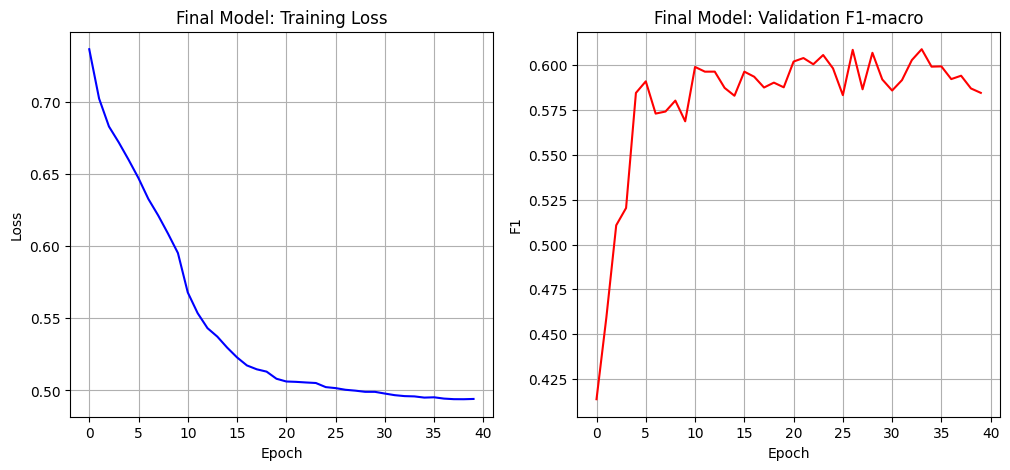

In [40]:
def plot_final_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss', color='blue')
    plt.title('Final Model: Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot F1
    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Val F1', color='red')
    plt.title('Final Model: Validation F1-macro')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.grid(True)
    
    plt.savefig('final_training_curves.png')
    plt.show()

plot_final_curves(history_v4_best)

In [41]:
!pip install grad-cam

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# ==========================================================
# 🔍 SECTION: EXPLAINABLE AI (Grad-CAM)
# ==========================================================

# 1. Setup Test DataLoader for XAI
# We need to recreate the loader so it's accessible globally
xai_test_ds = ODIRDataset(split='test', transform=get_transforms(configs['V4_Best']))
xai_test_loader = DataLoader(xai_test_ds, batch_size=32, shuffle=False)

def generate_xai_reports(model, test_loader, device, version_name, max_cases=2):
    model.eval()
    # Using the last convolutional layer of ResNet-50
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    xai_data_for_report = []
    
    counts = {"SUCCESS": 0, "FAILURE": 0}
    
    print(f"🕵️ Starting Explainable AI (Grad-CAM) for {version_name}...")

    for imgs, labels in test_loader:
        imgs_dev = imgs.to(device)
        outputs = model(imgs_dev)
        probs = torch.sigmoid(outputs) 
        preds = (probs > 0.5).int().cpu().numpy()
        labels_np = labels.numpy()
        probs_np = probs.detach().cpu().numpy()

        for i in range(imgs.shape[0]):
            # Check if all labels match (Multi-label correctness)
            is_correct = np.array_equal(preds[i], labels_np[i])
            type_str = "SUCCESS" if is_correct else "FAILURE"
            
            if counts[type_str] >= max_cases:
                continue

            counts[type_str] += 1
            
            # --- Generate Grad-CAM ---
            # Focus on the Ground Truth class to see what features the model noticed
            target_idx = labels_np[i].argmax() 
            targets = [ClassifierOutputTarget(target_idx)]
            
            grayscale_cam = cam(input_tensor=imgs_dev[i:i+1], targets=targets)[0, :]
            
            # Denormalize image for visualization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            img_original = imgs[i].permute(1, 2, 0).numpy()
            img_original = std * img_original + mean # Desfaz a normalização
            img_original = np.clip(img_original, 0, 1) # Garante intervalo [0, 1]            
            visualization = show_cam_on_image(img_original, grayscale_cam, use_rgb=True)

            # --- Save Composite Image ---
            filename = f"xai_{version_name.lower()}_{type_str}_case{i}.png"
            fig, ax = plt.subplots(1, 2, figsize=(15, 7))
            
            ax[0].imshow(img_original)
            ax[0].set_title(f"Original - Real Class: {classes[target_idx]}")
            ax[0].axis('off')
            
            ax[1].imshow(visualization)
            pred_idx = probs_np[i].argmax()
            ax[1].set_title(f"Grad-CAM {type_str}\nTop Prediction: {classes[pred_idx]} ({probs_np[i][pred_idx]:.2f})")
            ax[1].axis('off')
            
            plt.tight_layout()
            plt.savefig(f"/kaggle/working/{filename}")
            plt.close()

            # --- Metadata for Carolina & Matilde ---
            case_info = {
                "case_type": type_str,
                "image_file": filename,
                "ground_truth": [classes[j] for j, val in enumerate(labels_np[i]) if val == 1],
                "model_prediction": [classes[j] for j, val in enumerate(preds[i]) if val == 1],
                "confidence_scores": {classes[j]: float(probs_np[i][j]) for j in range(8)},
                "analyzed_class": classes[target_idx]
            }
            xai_data_for_report.append(case_info)
            print(f"✅ Generated: {filename}")

        if counts["SUCCESS"] >= max_cases and counts["FAILURE"] >= max_cases:
            break

    # Save JSON metadata file
    json_filename = f"xai_metadata_{version_name.lower()}.json"
    with open(f"/kaggle/working/{json_filename}", "w") as f:
        json.dump(xai_data_for_report, f, indent=4)
    
    print(f"\n📁 XAI Complete! Send '{json_filename}' and the generated images to your colleagues.")

# 2. Run XAI with the global xai_test_loader
generate_xai_reports(model, xai_test_loader, device, "V4_Best")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.4 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00

In [8]:
from torch.utils.data import WeightedRandomSampler

def get_weighted_sampler(df):
    target_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    labels = df[target_cols].values
    
    # Calcular contagem de classes no dataframe atual
    class_counts = labels.sum(axis=0)
    
    # Prevenção robusta contra divisão por zero:
    # Se uma classe não existir neste fold, atribuímos um peso neutro em vez de infinito
    class_weights = np.zeros_like(class_counts, dtype=np.float64)
    for i, count in enumerate(class_counts):
        if count > 0:
            class_weights[i] = 1.0 / count
        else:
            class_weights[i] = 0.0 # Se a classe não existe, peso é 0
            
    # Calcular peso de cada amostra
    sample_weights = np.dot(labels, class_weights)
    
    # --- CORREÇÃO CRÍTICA: GARANTIA DE VALIDADE ---
    # Converter para tensor para usar operações do PyTorch se necessário, ou manter numpy
    # Se a soma dos pesos for 0 (caso impossível se houver dados), forçamos distribuição uniforme
    if sample_weights.sum() <= 0:
        print("⚠️ Aviso: Sampler encontrou pesos zerados. Usando distribuição uniforme.")
        sample_weights = np.ones(len(df))
        
    # Adicionar um epsilon minúsculo para evitar zeros absolutos que o multinomial odeia
    sample_weights = sample_weights + 1e-8
    
    return WeightedRandomSampler(
        weights=sample_weights, 
        num_samples=len(sample_weights), 
        replacement=True
    )

In [9]:
# ==========================================================
# 🔄 FINAL FIX: 5-FOLD CV STABILIZED (ResNet-50 V4)
# ==========================================================
import torch.amp as amp
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import ConcatDataset, Subset

# --- 1. CONFIGURAÇÃO DE LOSS E CRITÉRIO ---
disease_classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
configs = {
    'V4_Best': {'crop': True, 'augment': 'full', 'clahe': True}
}
# Penalização reforçada: Errar classes raras custa mais ao modelo
pos_weights = torch.tensor([1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# --- 2. FUNÇÃO DE AVALIAÇÃO ROBUSTA (K-FOLD) ---
def evaluate_kfold(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for imgs, labels in loader:
            logits = model(imgs.to(device))
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    
    y_true = np.vstack(all_labels)
    y_prob = np.vstack(all_probs)
    
    # Testamos múltiplos thresholds para encontrar o potencial máximo do Fold
    best_f1 = 0
    for t in [0.1, 0.2, 0.3, 0.5]:
        f1 = f1_score(y_true, (y_prob > t).astype(int), average='macro', zero_division=0)
        if f1 > best_f1: best_f1 = f1
            
    acc = accuracy_score(y_true, (y_prob > 0.5).astype(int))
    try:
        auc = roc_auc_score(y_true, y_prob, average='macro')
    except:
        auc = 0.5 # Fallback se o fold for muito pequeno/desbalanceado
        
    return {'f1': best_f1, 'acc': acc, 'auc': auc}

# --- 3. LOOP DE CROSS-VALIDATION (USANDO CONCATDATASET PARA MANTER CAMINHOS ORIGINAIS) ---

# Primeiro, instanciamos os dois datasets originais separadamente para respeitar as pastas 'train' e 'val'
ds_train_base = ODIRDataset(split='train', transform=get_transforms(configs['V4_Best'], is_train=True))
ds_val_base = ODIRDataset(split='val', transform=get_transforms(configs['V4_Best'], is_train=False))

# Criamos o Dataset Unificado
full_dataset = ConcatDataset([ds_train_base, ds_val_base])

# Concatenamos os DataFrames internos para extrair os labels para o StratifiedKFold
# A tua classe já carregou ds_train_base.data e ds_val_base.data
full_df = pd.concat([ds_train_base.data, ds_val_base.data], ignore_index=True)
X_indices = np.arange(len(full_df))
y_labels = full_df[disease_classes].values

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold_results = []
scaler = amp.GradScaler() 

for fold, (train_idx, val_idx) in enumerate(mskf.split(X_indices, y_labels)):
    print(f"\n{'='*25} FOLD {fold+1}/5 {'='*25}")
    
    # Criamos Subsets baseados nos índices do K-Fold sem tocar na classe ODIRDataset
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    # Criar o Sampler usando o DataFrame fatiado para este fold
    df_fold_train = full_df.iloc[train_idx].reset_index(drop=True)
    sampler = get_weighted_sampler(df_fold_train)
    
    # Criar os Loaders
    train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    
    # --- Resto do Treino (Mantém-se igual ao teu código) ---
    model = get_optimized_resnet50(dropout_rate=0.5).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    best_fold_f1 = 0
    for epoch in range(14):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Fold {fold+1} Ep {epoch+1}", leave=False)
        
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device).float()
            optimizer.zero_grad(set_to_none=True)
            
            with amp.autocast(device_type='cuda'):
                outputs = model(imgs) 
                loss = criterion(outputs, labels)
        
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        
        metrics = evaluate_kfold(model, val_loader, device)
        scheduler.step(metrics['f1'])
        
        if metrics['f1'] > best_fold_f1:
            best_fold_f1 = metrics['f1']
            torch.save(model.state_dict(), f"resnet_fold{fold+1}_best.pth")
            
        print(f"Ep {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | F1: {metrics['f1']:.4f}")

    kfold_results.append({'fold': fold+1, 'acc': metrics['acc'], 'f1': best_fold_f1, 'auc': metrics['auc']})
    torch.cuda.empty_cache()
    
# --- 4. RELATÓRIO FINAL DE PERFORMANCE ---
print("\n" + "📊 FINAL K-FOLD PERFORMANCE SUMMARY")
print("="*60)
df_results = pd.DataFrame(kfold_results)
print(df_results.to_string(index=False))
print("-" * 60)
print(f"MÉDIA GERAL | Acc: {df_results['acc'].mean():.3f} | F1: {df_results['f1'].mean():.3f} | AUC: {df_results['auc'].mean():.3f}")
print(f"DESVIO PAD. | Acc: {df_results['acc'].std():.3f} | F1: {df_results['f1'].std():.3f} | AUC: {df_results['auc'].std():.3f}")
print("="*60)


========================= FOLD 1/5 =========================


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Ep 1 | Loss: 1.2059 | F1: 0.3228


Ep 2 | Loss: 0.8446 | F1: 0.3550


Ep 3 | Loss: 0.6591 | F1: 0.3659


Ep 4 | Loss: 0.5351 | F1: 0.4060


Ep 5 | Loss: 0.4611 | F1: 0.4112


Ep 6 | Loss: 0.3828 | F1: 0.4089


Ep 7 | Loss: 0.3347 | F1: 0.5005


Ep 8 | Loss: 0.2959 | F1: 0.4741


Ep 9 | Loss: 0.2665 | F1: 0.5075


Ep 10 | Loss: 0.2488 | F1: 0.5121


Ep 11 | Loss: 0.2201 | F1: 0.5048


Ep 12 | Loss: 0.2221 | F1: 0.5132


Ep 13 | Loss: 0.1994 | F1: 0.5410


Ep 14 | Loss: 0.1797 | F1: 0.5512

========================= FOLD 2/5 =========================


Ep 1 | Loss: 1.2011 | F1: 0.3058


Ep 2 | Loss: 0.8397 | F1: 0.3337


Ep 3 | Loss: 0.6514 | F1: 0.3801


Ep 4 | Loss: 0.5175 | F1: 0.3749


Ep 5 | Loss: 0.4432 | F1: 0.4255


Ep 6 | Loss: 0.3926 | F1: 0.4256


Ep 7 | Loss: 0.3254 | F1: 0.4362


Ep 8 | Loss: 0.2858 | F1: 0.4666


Ep 9 | Loss: 0.2615 | F1: 0.5026


Ep 10 | Loss: 0.2354 | F1: 0.4862


Ep 11 | Loss: 0.2276 | F1: 0.5093


Ep 12 | Loss: 0.2154 | F1: 0.4715


Ep 13 | Loss: 0.1925 | F1: 0.5157


Ep 14 | Loss: 0.1859 | F1: 0.5171

========================= FOLD 3/5 =========================


Ep 1 | Loss: 1.1829 | F1: 0.3286


Ep 2 | Loss: 0.8198 | F1: 0.3431


Ep 3 | Loss: 0.6670 | F1: 0.3518


Ep 4 | Loss: 0.5492 | F1: 0.3888


Ep 5 | Loss: 0.4585 | F1: 0.4235


Ep 6 | Loss: 0.3903 | F1: 0.4372


Ep 7 | Loss: 0.3355 | F1: 0.4392


Ep 8 | Loss: 0.3207 | F1: 0.4840


Ep 9 | Loss: 0.2713 | F1: 0.4863


Ep 10 | Loss: 0.2678 | F1: 0.4750


Ep 11 | Loss: 0.2364 | F1: 0.5102


Ep 12 | Loss: 0.1993 | F1: 0.5314


Ep 13 | Loss: 0.2260 | F1: 0.5074


Ep 14 | Loss: 0.1850 | F1: 0.5345

========================= FOLD 4/5 =========================


Ep 1 | Loss: 1.1828 | F1: 0.2996


Ep 2 | Loss: 0.8483 | F1: 0.3454


Ep 3 | Loss: 0.6550 | F1: 0.3596


Ep 4 | Loss: 0.5395 | F1: 0.3999


Ep 5 | Loss: 0.4539 | F1: 0.3981


Ep 6 | Loss: 0.3793 | F1: 0.4433


Ep 7 | Loss: 0.3379 | F1: 0.4679


Ep 8 | Loss: 0.3090 | F1: 0.4702


Ep 9 | Loss: 0.2679 | F1: 0.4747


Ep 10 | Loss: 0.2317 | F1: 0.5086


Ep 11 | Loss: 0.2334 | F1: 0.5419


Ep 12 | Loss: 0.2070 | F1: 0.5375


Ep 13 | Loss: 0.1972 | F1: 0.5191


Ep 14 | Loss: 0.1722 | F1: 0.5071

========================= FOLD 5/5 =========================


Ep 1 | Loss: 1.1989 | F1: 0.3182


Ep 2 | Loss: 0.8384 | F1: 0.3433


Ep 3 | Loss: 0.6363 | F1: 0.3564


Ep 4 | Loss: 0.5252 | F1: 0.3799


Ep 5 | Loss: 0.4495 | F1: 0.4155


Ep 6 | Loss: 0.3714 | F1: 0.4210


Ep 7 | Loss: 0.3263 | F1: 0.4495


Ep 8 | Loss: 0.2892 | F1: 0.4863


Ep 9 | Loss: 0.2599 | F1: 0.5006


Ep 10 | Loss: 0.2483 | F1: 0.4943


Ep 11 | Loss: 0.2147 | F1: 0.4775


Ep 12 | Loss: 0.2032 | F1: 0.5235


Ep 13 | Loss: 0.2030 | F1: 0.5408


Ep 14 | Loss: 0.1827 | F1: 0.5195

📊 FINAL K-FOLD PERFORMANCE SUMMARY
 fold      acc       f1      auc
    1 0.252294 0.551171 0.837226
    2 0.237922 0.517137 0.809861
    3 0.272475 0.534541 0.823919
    4 0.277164 0.541910 0.841290
    5 0.234043 0.540779 0.817024
------------------------------------------------------------
MÉDIA GERAL | Acc: 0.255 | F1: 0.537 | AUC: 0.826
DESVIO PAD. | Acc: 0.020 | F1: 0.013 | AUC: 0.013
